# Imports

In [2]:
# Our tools
import exoplanet as xo
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import lightkurve as lk
from astropy.io import fits
from astropy.timeseries import BoxLeastSquares
from scipy import stats
import graphviz
import astropy.units as u
from astropy.timeseries import LombScargle

import pymc3 as pm
import aesara_theano_fallback.tensor as tt
import pymc3_ext as pmx
from functools import partial

import os
import warnings
#os.environ["MKL_THREADING_LAYER"] = "GNU"
#warnings.filterwarnings("ignore", category=DeprecationWarning)
#warnings.filterwarnings("ignore", category=FutureWarning)

<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline
plt.style.use('seaborn-dark-palette')

/tmp/ipykernel_49133/1667230561.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-dark-palette')


In [4]:
plt.rcParams["figure.figsize"]=8,6
plt.rcParams.update({'font.size': 16})

# Data

## Tess

In [5]:
#sectors times, 15-22-23-48-50
from astropy.time import Time
sectors = ['2019-08-15T20:45:00','2019-09-10T22:00:00','2019-09-12T03:40:00','2019-10-06T19:50:00','2020-02-19T19:20:00','2020-03-18T00:00:00',
'2020-03-19T14:30:00','2020-04-15T09:10:00','2022-01-28T10:25:00','2022-02-25T11:50:00','2022-03-26T18:30:00','2022-04-22T00:25:00']
sectors_times = Time(sectors, format='fits')
sectors_times_btjd = sectors_times.jd-2457000
sectors_times_btjd

array([1711.36458333, 1737.41666667, 1738.65277778, 1763.32638889,
       1899.30555556, 1926.5       , 1928.10416667, 1954.88194444,
       2607.93402778, 2635.99305556, 2665.27083333, 2691.51736111])

In [6]:
lk.search_targetpixelfile('TIC 445859771')

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 15,2019,SPOC,120,445859771,0.0
1,TESS Sector 15,2019,TESS-SPOC,1800,445859771,0.0
2,TESS Sector 16,2019,TESS-SPOC,1800,445859771,0.0
3,TESS Sector 22,2020,SPOC,120,445859771,0.0
4,TESS Sector 22,2020,TESS-SPOC,1800,445859771,0.0
5,TESS Sector 23,2020,SPOC,120,445859771,0.0
6,TESS Sector 23,2020,TESS-SPOC,1800,445859771,0.0
7,TESS Sector 48,2022,SPOC,120,445859771,0.0
8,TESS Sector 48,2022,TESS-SPOC,600,445859771,0.0


In [7]:
tpf = lk.search_targetpixelfile('TIC 445859771', exptime='short', sector=22).download(quality_bitmask='default')

<Axes: title={'center': 'Target ID: 445859771, Cadence: 483733'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>

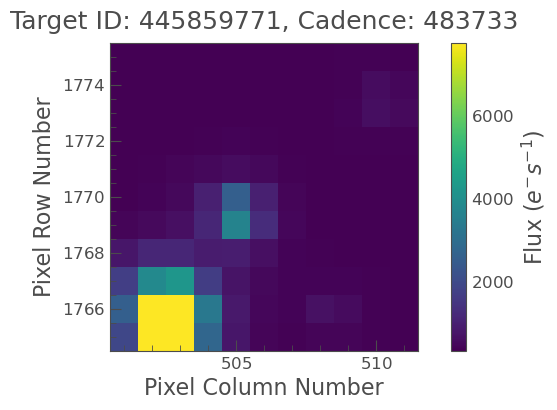

In [8]:
tpf.plot()

In [9]:
# !python ~/Descargas/tpfplotter/tpfplotter.py 445859771 --maglim 6 --sector 16

In [10]:
lk.search_lightcurve('TIC 445859771')

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 15,2019,SPOC,120,445859771,0.0
1,TESS Sector 15,2019,TESS-SPOC,1800,445859771,0.0
2,TESS Sector 15,2019,QLP,1800,445859771,0.0
3,TESS Sector 15,2019,TASOC,120,445859771,0.0
4,TESS Sector 15,2019,TASOC,1800,445859771,0.0
5,TESS Sector 15,2019,TASOC,1800,445859771,0.0
6,TESS Sector 16,2019,TESS-SPOC,1800,445859771,0.0
7,TESS Sector 16,2019,QLP,1800,445859771,0.0
8,TESS Sector 22,2020,SPOC,120,445859771,0.0


In [11]:
lk.search_lightcurve('TIC 445859771', exptime=1800)

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 15,2019,TESS-SPOC,1800,445859771,0.0
1,TESS Sector 15,2019,QLP,1800,445859771,0.0
2,TESS Sector 15,2019,TASOC,1800,445859771,0.0
3,TESS Sector 15,2019,TASOC,1800,445859771,0.0
4,TESS Sector 16,2019,TESS-SPOC,1800,445859771,0.0
5,TESS Sector 16,2019,QLP,1800,445859771,0.0
6,TESS Sector 22,2020,TESS-SPOC,1800,445859771,0.0
7,TESS Sector 22,2020,QLP,1800,445859771,0.0
8,TESS Sector 23,2020,TESS-SPOC,1800,445859771,0.0


In [12]:
lc_file_long = lk.search_lightcurve('TIC 445859771', exptime=1800, author='TESS-SPOC', sector=16).download_all(flux_column="pdcsap_flux")

<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

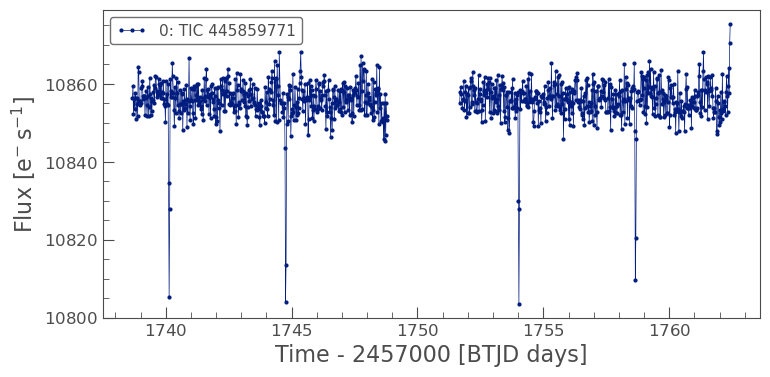

In [13]:
lc_file_long.plot(marker='o')
#plt.xlim(1890, 1910)

In [14]:
lc_file_sap = lk.search_lightcurve('TIC 445859771', author='SPOC').download_all(flux_column="sap_flux")

<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

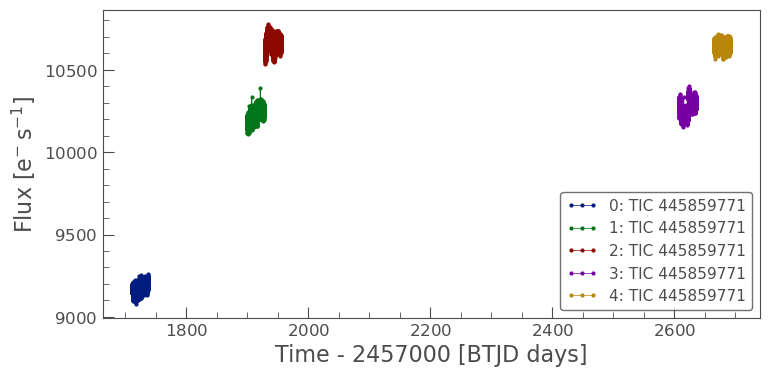

In [15]:
lc_file_sap.plot(marker='o')

<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Normalized Flux'>

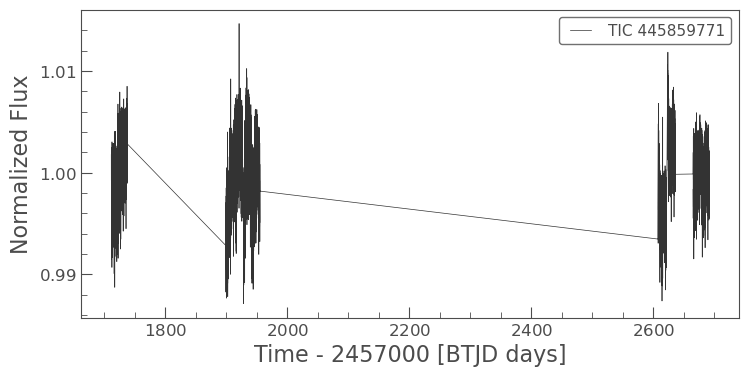

In [16]:
lc2 = lc_file_sap.stitch().remove_nans().normalize()
lc2.plot()
#plt.xlim(1895, 1960)
#plt.ylim(0.985, 1.015)

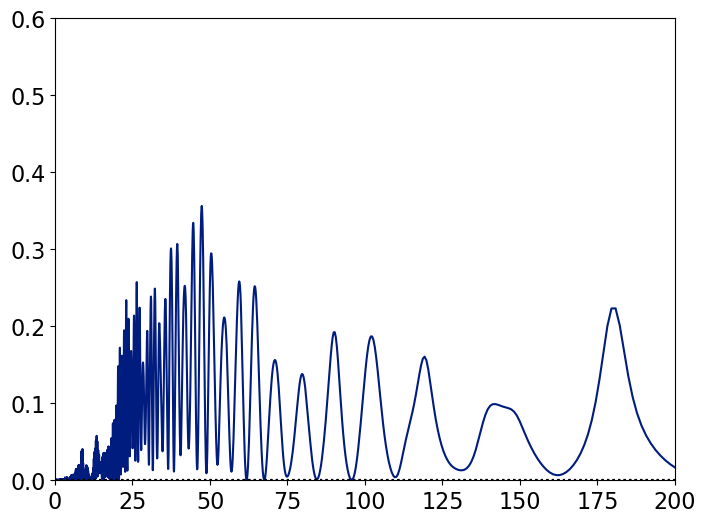

In [17]:
ls_tess = LombScargle(lc2.time.value, lc2.flux, lc2.flux_err)
frequency_tess, power_tess = ls_tess.autopower(minimum_frequency=0.001, maximum_frequency=10, samples_per_peak=25)
plt.plot(1/frequency_tess, power_tess) 
plt.ylim(0,0.6)
plt.xlim(0,200)
probabilities = [0.1, 0.05, 0.01]
faps_tess = ls_tess.false_alarm_level(probabilities)  
for i, prob in enumerate(probabilities):
    plt.axhline(faps_tess[i], ls=':', color='black', label='{}%'.format(prob))



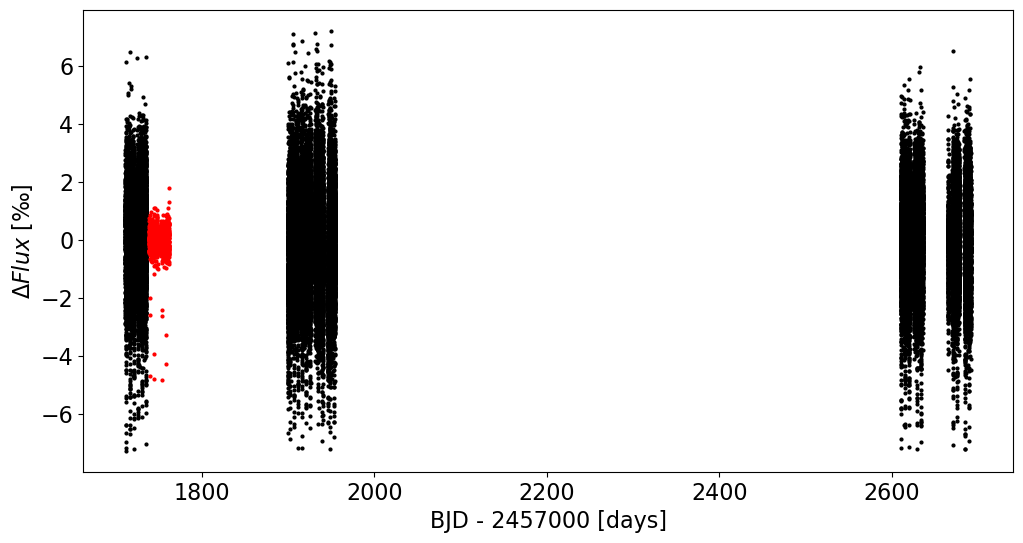

In [18]:
lc_file = lk.search_lightcurve('TIC 445859771', author='SPOC').download_all(flux_column="pdcsap_flux")
lc = lc_file.stitch().remove_nans().normalize().remove_outliers()
time = lc.time.value
flux = lc.flux

lc_long = lc_file_long.stitch().remove_nans().normalize()
time_long = lc_long.time.value
flux_long = lc_long.flux


with fits.open(lc_file[0].filename) as hdu:
    hdr = hdu[1].header
with fits.open(lc_file_long[0].filename) as hdu:
    hdr_long = hdu[1].header

texp_long = hdr_long["FRAMETIM"] * hdr_long["NUM_FRM"]
texp_long /= 60.0 * 60.0 * 24.0
texp = hdr["FRAMETIM"] * hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0

ref_time = 0.5 * (np.min(time) + np.max(time))
x_ = np.ascontiguousarray(time - ref_time, dtype=np.float64)
y_ = np.ascontiguousarray(1e3 * (flux - 1.0), dtype=np.float64) # Here we convert flux to ppt
yerr_ = np.ascontiguousarray(1e3 * lc.flux_err, dtype=np.float64)

xlong_ = np.ascontiguousarray(time_long - ref_time, dtype=np.float64)
ylong_ = np.ascontiguousarray(1e3 * (flux_long - 1.0), dtype=np.float64) # Here we convert flux to ppt
yerrlong_ = np.ascontiguousarray(1e3 * lc_long.flux_err, dtype=np.float64)

plt.figure(figsize=(12, 6))
plt.plot(time, y_, "o", color='black',markersize=2)
plt.plot(time_long, ylong_, "o", color='red',markersize=2)
#plt.errorbar(time, (flux-1.0)*1e3, yerr=lc.flux_err*1e3, color='k', fmt='o', ms=2)
plt.xlabel("BJD - 2457000 [days]")
plt.ylabel(u'$\Delta Flux$ [‰]')
plt.show()
#plt.savefig('tessdata_1199.png',dpi=300,bbox_inches='tight')

In [19]:
sectors_times_btjd[:4]

array([1711.36458333, 1737.41666667, 1738.65277778, 1763.32638889])

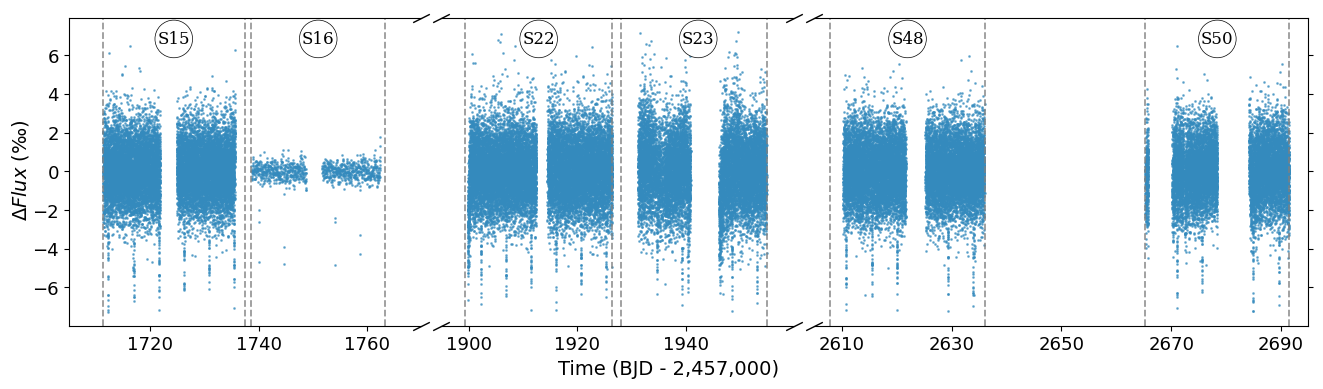

In [20]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharey=True, figsize=(16,4), gridspec_kw={'width_ratios': [1, 1, 1.4]})
fig.subplots_adjust(wspace=0.05)
ax1.plot(time, y_, "o", color='#348ABD', markersize=1, alpha=0.6)
ax1.plot(time_long, ylong_, "o", color='#348ABD', markersize=1, alpha=0.6)
ax2.plot(time, y_, "o", color='#348ABD', markersize=1, alpha=0.6)
ax3.plot(time, y_, "o", color='#348ABD', markersize=1, alpha=0.6)
ax1.set_xlim(1705, 1770)  
ax2.set_xlim(1895, 1960)  
ax3.set_xlim(2605, 2695)  
ax2.set_xticks([1900, 1920, 1940])
ax3.set_xticks([2610, 2630, 2650, 2670, 2690])
ax1.spines.right.set_visible(False)
ax2.spines.right.set_visible(False)
ax2.spines.left.set_visible(False)
ax3.spines.left.set_visible(False)
ax1.yaxis.tick_left()
#ax2.set_yticks([])
ax2.yaxis.tick_right()
ax3.yaxis.tick_right()
ax1.tick_params(labelright=False)
ax2.tick_params(axis='y', which='both', left=False, right=False, labelright=False, labelleft=False)
ax3.tick_params(labelleft=False)
ax1.tick_params(axis='both', which='major', labelsize=13)
ax2.tick_params(axis='both', which='major', labelsize=13)
ax3.tick_params(axis='both', which='major', labelsize=13)

d = .5  
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12, 
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)

ax1.plot([1, 1], [0, 1], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 0], [1, 0], transform=ax2.transAxes, **kwargs)
ax2.plot([1, 1], [0, 1], transform=ax2.transAxes, **kwargs)
ax3.plot([0, 0], [1, 0], transform=ax3.transAxes, **kwargs)
for i in sectors_times_btjd[:4]:
    ax1.axvline(x=i, color='gray', linestyle='--', linewidth=1.3, alpha=0.8)
for i in sectors_times_btjd[4:8]:
    ax2.axvline(x=i, color='gray', linestyle='--', linewidth=1.3, alpha=0.8)
for i in sectors_times_btjd[8:]:
    ax3.axvline(x=i, color='gray', linestyle='--', linewidth=1.3, alpha=0.8)
ax1.text(sectors_times_btjd[0]+(sectors_times_btjd[1]-sectors_times_btjd[0])/2, 6.85, 
    "S15", ha="center", va="center", size=12, fontfamily='serif',
    bbox=dict(boxstyle="circle,pad=0.15", fc='white', lw=0.5))
ax1.text(sectors_times_btjd[2]+(sectors_times_btjd[3]-sectors_times_btjd[2])/2, 6.85, 
    "S16", ha="center", va="center", size=12, fontfamily='serif',
    bbox=dict(boxstyle="circle,pad=0.15", fc='white', lw=0.5))
ax2.text(sectors_times_btjd[4]+(sectors_times_btjd[5]-sectors_times_btjd[4])/2, 6.85, 
    "S22", ha="center", va="center", size=12, fontfamily='serif',
    bbox=dict(boxstyle="circle,pad=0.15", fc='white', lw=0.5))
ax2.text(sectors_times_btjd[6]+(sectors_times_btjd[7]-sectors_times_btjd[5])/2, 6.85, 
    "S23", ha="center", va="center", size=12, fontfamily='serif',
    bbox=dict(boxstyle="circle,pad=0.15", fc='white', lw=0.5))
ax3.text(sectors_times_btjd[8]+(sectors_times_btjd[9]-sectors_times_btjd[8])/2, 6.85, 
    "S48", ha="center", va="center", size=12, fontfamily='serif',
    bbox=dict(boxstyle="circle,pad=0.15", fc='white', lw=0.5))
ax3.text(sectors_times_btjd[10]+(sectors_times_btjd[11]-sectors_times_btjd[10])/2, 6.85, 
    "S50", ha="center", va="center", size=12, fontfamily='serif',
    bbox=dict(boxstyle="circle,pad=0.15", fc='white', lw=0.5))

fig.text(0.5, 0.001, "Time (BJD - 2,457,000)", ha='center', va='center', size=14)
fig.text(0.095, 0.5, u'$\Delta Flux$ (‰)', ha='center', va='center', rotation='vertical', size=14)
#plt.savefig('tessdata_1273.png',dpi=300,bbox_inches='tight', facecolor='white')
plt.show()

### BLS

In [21]:
xt = np.concatenate((xlong_, x_), axis=0)
yt = np.concatenate((ylong_, y_), axis=0)
yerrt = np.concatenate((yerrlong_, yerr_), axis=0)

In [22]:
period_grid = np.exp(np.linspace(np.log(2), np.log(8), 30000)) #2 y 8 ---- 1 y 30
durations = np.exp(np.linspace(np.log(0.01), np.log(0.2), 100)) #0.01 y 0.2 

bls = BoxLeastSquares(x_, y_, yerr_)
bls_power = bls.power(period_grid, durations, oversample=30)

# Save the highest peak as the planet candidate
index = np.argmax(bls_power.power)
bls_period = bls_power.period[index]
bls_t0 = bls_power.transit_time[index]
bls_depth = bls_power.depth[index]
bls_duration = bls_power.duration[index]

print('bls period:',bls_period)
print('bls t0:',bls_t0)
print('bls depth:',bls_depth)
print('ref_time:', ref_time)
print('epoch:', bls_t0 + ref_time)
print('bls duration:', bls_duration*24)

bls period: 4.631374375019575
bls t0: -489.0987763358155
bls depth: 3.6049340566184895
ref_time: 2201.436872421974
epoch: 1712.3380960861584
bls duration: 1.2640000000000002


In [23]:
# tess project fit
spoc_depth = 4.860 
spoc_duration = 1.435/24
spoc_period = 4.631301

In [24]:
# 50000, 1000, 30
# bls period: 4.631322521004829
# bls t0: -489.09344300248216
# bls depth: 3.900957369574416
# ref_time: 2201.436872421974
# epoch: 1712.3434294194917
# bls duration: 1.1840000000000004

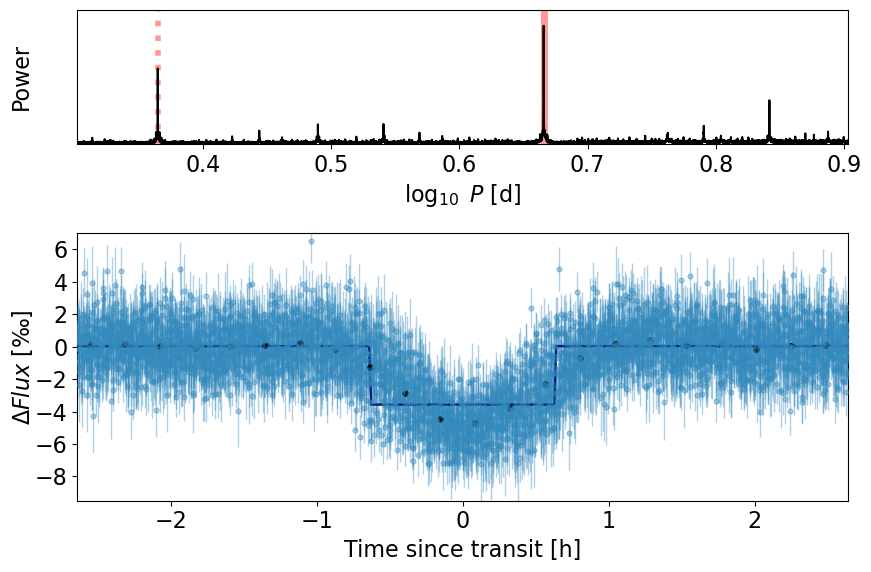

In [25]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 6), gridspec_kw={'height_ratios': [1, 2]})
fig.subplots_adjust(hspace=0.35)

ax1.axvline(np.log10(bls_period), color='red', lw=5, alpha=0.4)
ax1.axvline(np.log10(bls_period/2), linestyle='dotted', color='red', lw=4, alpha=0.4)
ax1.axvline(np.log10(bls_period/3), linestyle='dotted', color='red', lw=4, alpha=0.4)
ax1.axvline(np.log10(bls_period/4), linestyle='dotted', color="red", lw=4, alpha=0.4)
ax1.axvline(np.log10(bls_period*2), linestyle='dotted', color="red", lw=4, alpha=0.4)
ax1.axvline(np.log10(bls_period*3), linestyle='dotted', color="red", lw=4, alpha=0.4)
ax1.axvline(np.log10(bls_period*4), linestyle='dotted', color="red", lw=4, alpha=0.4)
ax1.plot(np.log10(bls_power.period), bls_power.power, color="k")
ax1.set_ylim(0,3000)
ax1.set_ylabel("Power", labelpad=32)
ax1.set_yticks([])
ax1.set_xlim(np.log10(period_grid.min())+0.001, np.log10(period_grid.max()))
ax1.set_xlabel(r"$\log_{10}~ P$ [d]")

# Plot the folded transit
x_fold_ = (x_ - bls_t0 + 0.5 * bls_period) % bls_period - 0.5 * bls_period
x_fold_long = (xlong_ - bls_t0 + 0.5 * bls_period) % bls_period - 0.5 * bls_period
xt_fold = (xt - bls_t0 + 0.5 * bls_period) % bls_period - 0.5 * bls_period
# x_fold_ = (x_ - t0_ + 0.5 * p_) % p_ - 0.5 * p_
# x_fold_long = (xlong_ - t0_ + 0.5 * p_) % p_ - 0.5 * p_
# xt_fold = (xt - t0_ + 0.5 * p_) % p_ - 0.5 * p_

# ax2.plot(x_fold_long*24, ylong_, ".", alpha=0.6, ms=4, color='r', zorder=102)
# ax2.errorbar(x_fold_long*24, ylong_, yerr=yerrlong_, color='r', fmt="none", capsize=0, elinewidth=1, zorder=10000, alpha=0.5)
# ax2.plot(x_fold_*24, y_, ".", alpha=0.7, ms=5, color='#348ABD', zorder=101)
# ax2.errorbar(x_fold_*24, y_, yerr=yerr_, fmt="none", color='#348ABD', elinewidth=1, alpha=0.2, capsize=0, zorder=10000)
ax2.plot(xt_fold*24, yt, ".", alpha=0.4, ms=7, color='#348ABD', zorder=100)
ax2.errorbar(xt_fold*24, yt, yerr=yerrt, fmt="none", color='#348ABD', elinewidth=1, alpha=0.4, capsize=0)
ax2.set_ylim(-8,6)
ax2.set_yticks([-8,-6,-4,-2,0,2,4,6])

# Overplot the phase binned light curve
lcc = lk.LightCurve(time=xt_fold, flux=yt, flux_err=yerrt)
lcc_binned = lcc.bin(time_bin_size=0.01)
ax2.errorbar(lcc_binned['time'].value*24, lcc_binned['flux'].value, yerr=lcc_binned['flux_err'].value, fmt='o', color='k', 
                ms=5, markeredgecolor='k', markerfacecolor='k', markeredgewidth=0, capsize=2, alpha=0.8)
ax2.set_xlim(-0.11*24, 0.11*24)
ax2.set_ylim(-9.5, 7)
ax2.set_yticks([-8,-6,-4,-2,0,2,4,6])
ax2.set_ylabel(u'$\Delta Flux$ [‰]', labelpad=0)
_ = ax2.set_xlabel("Time since transit [h]")

# plot the BLS model
x_bin = np.linspace(-0.3, 0.3, 1000)
f = bls.model(x_bin + bls_t0, bls_period, bls_duration, bls_t0)
ax2.plot(x_bin*24, f, lw=1.75)
plt.tight_layout()

#plt.savefig('bls_paper_1273.png', dpi=300,bbox_inches='tight', facecolor='white')

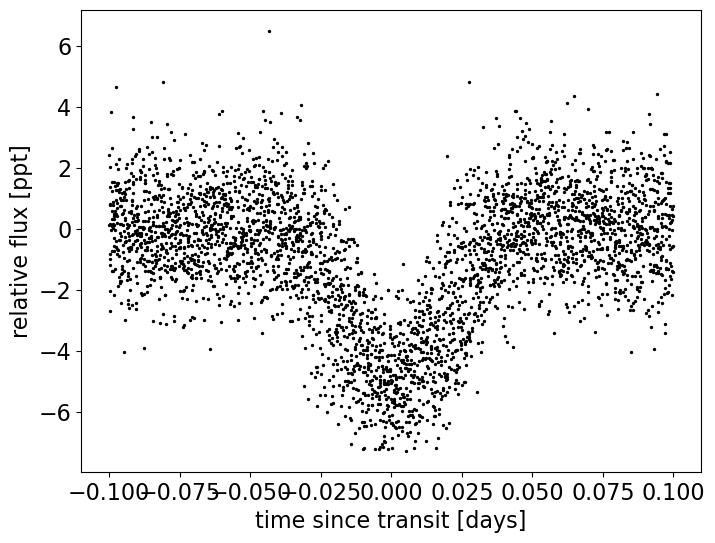

In [26]:
transit_mask = bls.transit_mask(x_, bls_period, 0.2, bls_t0)
transit_mask_long = bls.transit_mask(xlong_, bls_period, 0.2, bls_t0)
x_fold_ = (x_ - bls_t0 + 0.5*bls_period) % bls_period - 0.5*bls_period

# Me quedo solo con los puntos cerca de los transitos
x_fold = x_fold_[transit_mask]
x = x_[transit_mask]
y = y_[transit_mask]
yerr = yerr_[transit_mask]

xlong = xlong_[transit_mask_long]
ylong = ylong_[transit_mask_long]
yerrlong = yerrlong_[transit_mask_long]

plt.scatter(x_fold, y, c='k', s=2)
plt.xlabel("time since transit [days]")
plt.ylabel("relative flux [ppt]");
#plt.xlim(-0.12,0.12)

In [27]:
len(x)

3530

## SOPHIE RVs

60


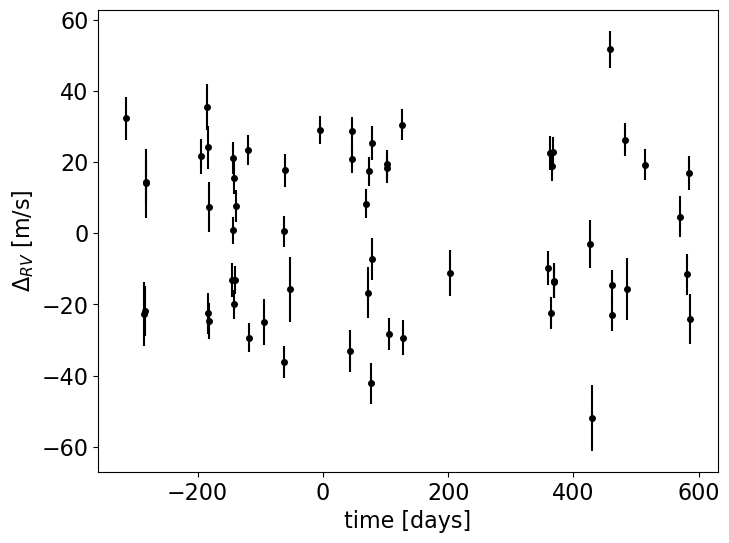

In [28]:
data = pd.read_table('./data/rvs/1273_final_rvs.dat', sep='\s+')
data.rename(columns={'rv(km/s)': 'rv', 'sigRV(km/s)':'err', 'bis(km/s)': 'bis'}, inplace=True)

x_rv = np.array(data.bjd+2400000-2457000)-ref_time
y_rv = np.array((data.rv-data.rv.mean())*1000)
yerr_rv = np.array(data.err*1000)

plt.errorbar(x_rv, y_rv, yerr=yerr_rv, fmt=".k", markersize=8)
plt.xlabel("time [days]")
print(len(x_rv))
_ = plt.ylabel("$\Delta_{RV}$ [m/s]")

In [29]:
# Compute a reference time that will be used to normalize the trends model
x_ref = 0.5 * (x_rv.min() + x_rv.max())

# Stellar parameters from Sousa
M_star = 0.98, 0.02
R_star = 1.07, 0.03

K = xo.estimate_semi_amplitude(bls_period, x_rv, y_rv, yerr_rv, t0s=bls_t0)
print('K=', K, "m/s")

msini = xo.estimate_minimum_mass(bls_period, x_rv, y_rv, yerr_rv, t0s=bls_t0, m_star=M_star[0])
msini = msini.to(u.M_earth)
print('minimum mass=', msini)

K= [26.47708999] m/s
minimum mass= [68.09246812] earthMass


Periodograms

In [30]:
# read de BIS data
ls = LombScargle(data.bjd, data.rv, data.err)
ls_bis = LombScargle(data.bjd, data.bis)
ls_w = LombScargle(data.bjd, np.ones(len(data.bjd)), data.err, fit_mean=False, center_data=False)

frequency, power = ls.autopower(minimum_frequency=0.001, maximum_frequency=2, samples_per_peak=5)

frequency_bis, power_bis = ls_bis.autopower(minimum_frequency=0.001, maximum_frequency=2, samples_per_peak=5)

frequency_window, power_window = ls_w.autopower(minimum_frequency=0.001, maximum_frequency=2, samples_per_peak=15)

probabilities = [0.1, 0.05, 0.01]
faps = ls.false_alarm_level(probabilities)  
faps_bis = ls_bis.false_alarm_level(probabilities)

In [31]:
# aliases computed in DACE
aliases = [1.275, 1.271, 0.822, 0.821]

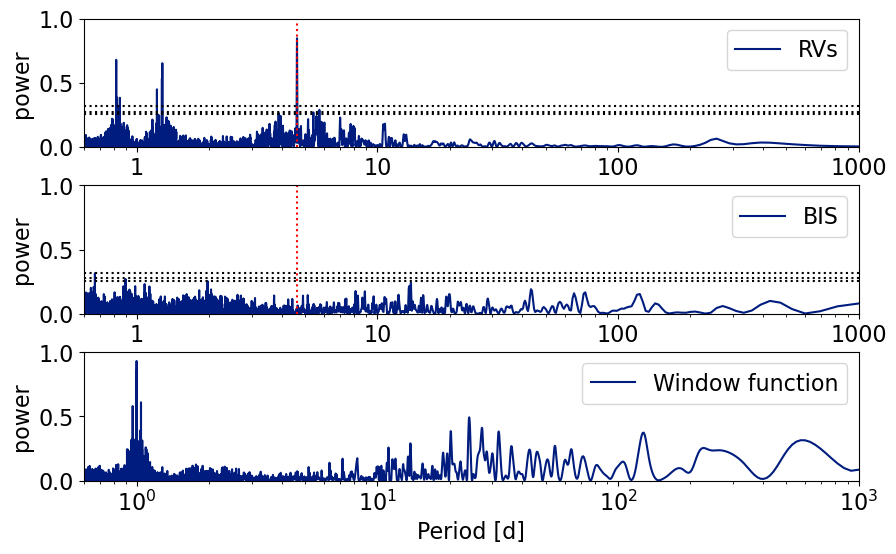

In [32]:
from matplotlib.ticker import ScalarFormatter
# plot two figures in a column
fig, axes = plt.subplots(3, 1, sharex=False, figsize=(10, 6))
axes[0].plot(1/frequency, power, label='RVs') 
axes[1].plot(1/frequency_bis, power_bis, label='BIS') 
axes[2].plot(1/frequency_window, power_window, label='Window function')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)

axes[0].set_xlabel('')
axes[0].set_xlim(0.6, 1000)
axes[0].set_ylim(0, 1.0)
axes[1].set_xlabel('')
axes[1].set_xlim(0.6, 1000)
axes[1].set_ylim(0, 1.0)
axes[2].set_xlabel('Period [d]')
axes[2].set_xlim(0.6, 1000)
axes[2].set_ylim(0, 1.0)

axes[0].set_xscale('log')
axes[1].set_xscale('log')
axes[2].set_xscale('log')

axes[0].set_ylabel('power')
axes[1].set_ylabel('power')
axes[2].set_ylabel('power')
axes[0].legend(loc='upper right')
axes[1].legend(loc='upper right')
axes[2].legend(loc='upper right')
# overplot the false alarm probabilities
for i, prob in enumerate(probabilities):
    axes[0].axhline(faps[i], ls=':', color='black', label='{}%'.format(prob))
    axes[1].axhline(faps_bis[i], ls=':', color='black', label='{}%'.format(prob))

# plot the 'bls_period' as a vertical line behind the plot
axes[0].axvline(bls_period, ls=':', color='red', label='bls period')
axes[1].axvline(bls_period, ls=':', color='red', label='bls period')

formatter = ScalarFormatter()
axes[0].xaxis.set_major_formatter(formatter)
axes[1].xaxis.set_major_formatter(formatter)
#plt.savefig('bisrv_periodogram_1273.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

In [33]:
def windowfunction(t, erv, prange):

    w = (1/erv**2)/np.sum(1/erv**2)

    wf = np.zeros(len(prange))

    for i in range(len(prange)):

        omega = 2 * np.pi / prange[i]

        ccos = np.cos(omega*t)
        ssin = np.sin(omega*t)

        wC = np.sum(w*ccos)
        wS = np.sum(w*ssin)

        wC = np.sum(ccos)/len(ccos)
        wS = np.sum(ssin)/len(ssin)

        wf[i] = wC * wC + wS * wS
    return wf

In [34]:
prange = np.logspace(-1, 3, 100000)
wf = windowfunction(data.bjd, data.err, prange)
wf

array([0.01302173, 0.05095282, 0.02618594, ..., 0.03396419, 0.03396584,
       0.03396751])

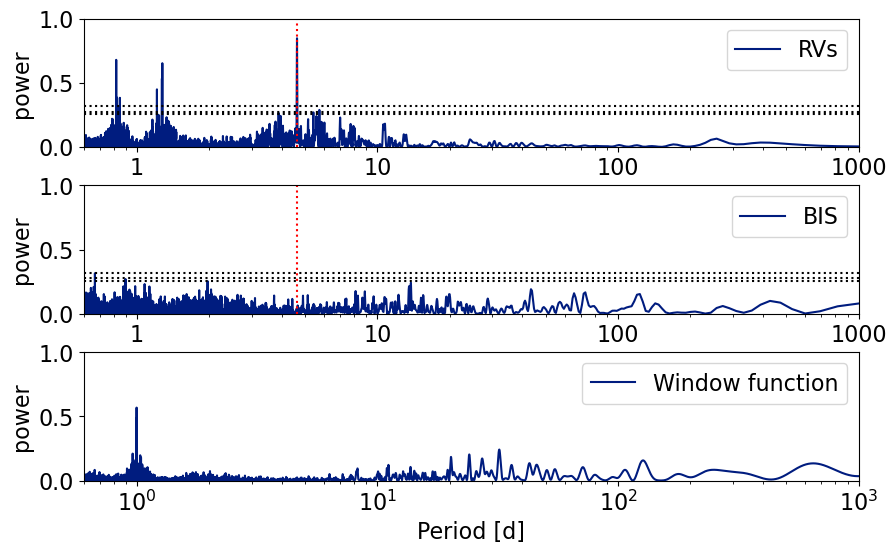

In [35]:
fig, axes = plt.subplots(3, 1, sharex=False, figsize=(10, 6))
axes[0].plot(1/frequency, power, label='RVs') 
axes[1].plot(1/frequency_bis, power_bis, label='BIS') 
axes[2].plot(prange, wf, label='Window function')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)

axes[0].set_xlabel('')
axes[0].set_xlim(0.6, 1000)
axes[0].set_ylim(0, 1.0)
axes[1].set_xlabel('')
axes[1].set_xlim(0.6, 1000)
axes[1].set_ylim(0, 1.0)
axes[2].set_xlabel('Period [d]')
axes[2].set_xlim(0.6, 1000)
axes[2].set_ylim(0, 1.0)

axes[0].set_xscale('log')
axes[1].set_xscale('log')
axes[2].set_xscale('log')

axes[0].set_ylabel('power')
axes[1].set_ylabel('power')
axes[2].set_ylabel('power')
axes[0].legend(loc='upper right')
axes[1].legend(loc='upper right')
axes[2].legend(loc='upper right')
# overplot the false alarm probabilities
for i, prob in enumerate(probabilities):
    axes[0].axhline(faps[i], ls=':', color='black', label='{}%'.format(prob))
    axes[1].axhline(faps_bis[i], ls=':', color='black', label='{}%'.format(prob))

# plot the 'bls_period' as a vertical line behind the plot
axes[0].axvline(bls_period, ls=':', color='red', label='bls period')
axes[1].axvline(bls_period, ls=':', color='red', label='bls period')

formatter = ScalarFormatter()
axes[0].xaxis.set_major_formatter(formatter)
axes[1].xaxis.set_major_formatter(formatter)
#plt.savefig('bisrv_periodogram_1273.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

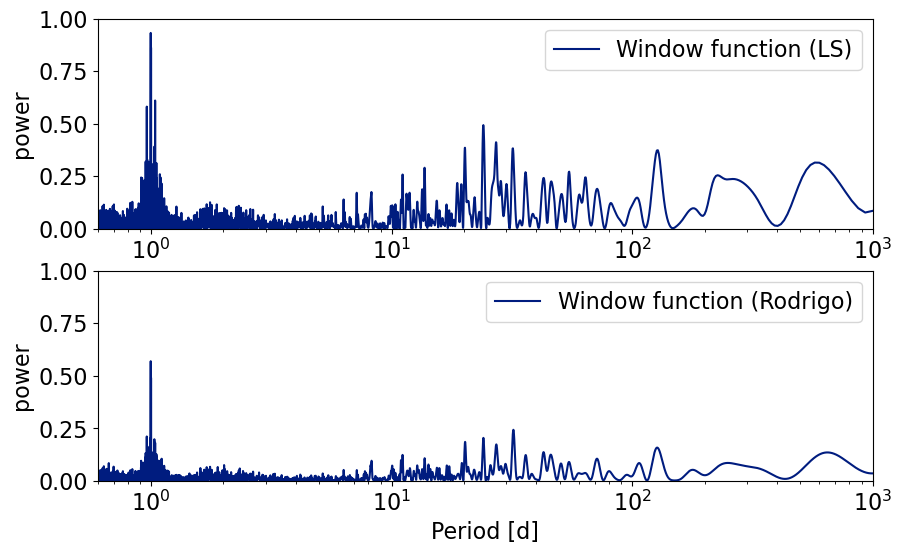

In [36]:
fig, axes = plt.subplots(2,1, figsize=(10, 6))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.2)
axes[0].plot(1/frequency_window, power_window, label='Window function (LS)')
axes[1].plot(prange, wf, label='Window function (Rodrigo)')
axes[0].set_xlabel('')
axes[1].set_xlabel('Period [d]')
axes[0].set_xlim(0.6, 1000)
axes[0].set_ylim(0, 1.0)
axes[1].set_xlim(0.6, 1000)
axes[1].set_ylim(0, 1.0)
axes[0].set_xscale('log')
axes[1].set_xscale('log')
axes[0].set_ylabel('power')
axes[1].set_ylabel('power')
axes[0].legend(loc='upper right')
axes[1].legend(loc='upper right')
#plt.savefig('windowfunction_1273.png', dpi=300, bbox_inches='tight', facecolor='white')

BIS vs rvs

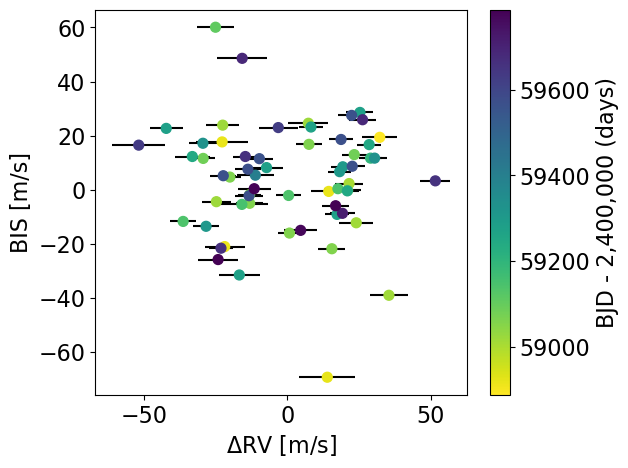

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
g = ax.scatter(y_rv, data.bis*1e3, c=data.bjd, cmap='viridis_r', s=50, zorder=10)
# add errorbars on data.rv
ax.errorbar(y_rv, data.bis*1e3, xerr=yerr_rv, fmt='none', ecolor='k', markersize=8, zorder=-10)
ax.set_xlabel("$\Delta$RV [m/s]")
ax.set_ylabel("BIS [m/s]")
fig.colorbar(g, label='BJD - 2,400,000 (days)')
#plt.savefig('bisrv_1273.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

## Ground LCs

### Keplercam

In [38]:
# all have the same columns
data1 = pd.read_table('./data/photom/TOI1273/KEPLERCAM/TIC445859771.01_UT2020.0213_KeplerCam_B.txt', sep='\s+')

In [39]:
#puntos?
print('puntos:', len(data1))
# texp?
texp_keplercam = None

puntos: 135


In [40]:
data1['flux'] = ((data1['rel_flux_T1']/(data1['rel_flux_T1'].median())))*1e3
data1['time'] = data1['BJD_TDB']-2457000-ref_time
data1['flux_err'] = ((data1['rel_flux_err_T1']/(data1['rel_flux_T1'].median())))*1e3

In [41]:
out_mask1 = np.abs(data1.flux-data1.flux.mean())<3*data1.flux.std()
print(len(data1))
data1 = data1[out_mask1]
print(len(data1))

k_mask1 = bls.transit_mask(data1['time'], bls_period, 0.2, bls_t0)
data1 = data1[k_mask1]
print(len(data1))

135
135
135


Text(0.5, 1.0, 'TOI1273')

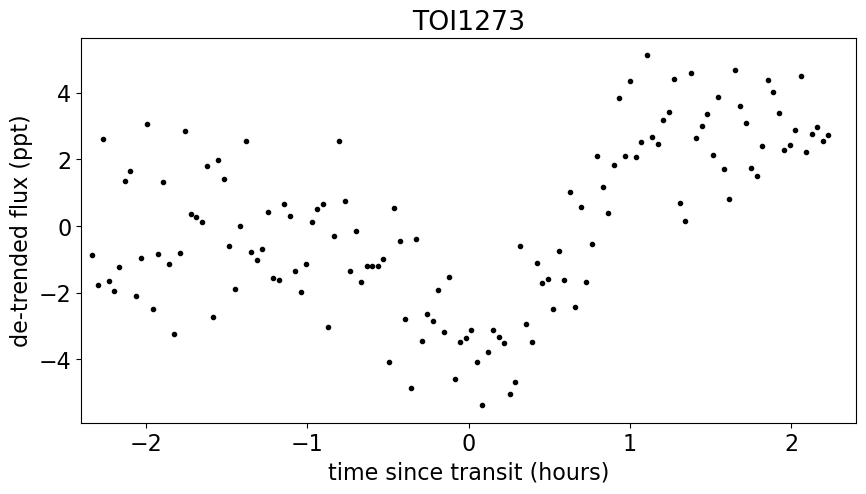

In [42]:
# Plot the folded data, con los parametros del BLS
data1_fold = (data1['time'] - bls_t0 + 0.5 * bls_period) % bls_period - 0.5 * bls_period
plt.figure(figsize=(10, 5))
plt.plot(data1_fold*24, data1['flux']-1e3, ".k", label="data1", zorder=-1000)
plt.ylabel("de-trended flux (ppt)")
plt.xlabel('time since transit (hours)')
plt.xlim(-0.10*24, 0.10*24)
plt.title("TOI1273")

In [43]:
# ajustemos un pol grado 2 a los datos oot
# mascaras para sacar los datos en transito
oot_mask1 = bls.transit_mask(data1['time'], spoc_period, spoc_duration, bls_t0)
x_oot_B = (data1_fold*24)[~oot_mask1]
y_oot_B = data1['flux'][~oot_mask1]
z_B = np.polyfit(x_oot_B, y_oot_B, 2)
def pol_B(x):
    return np.asarray(z_B[0]*x**2 + z_B[1]*x + z_B[2])

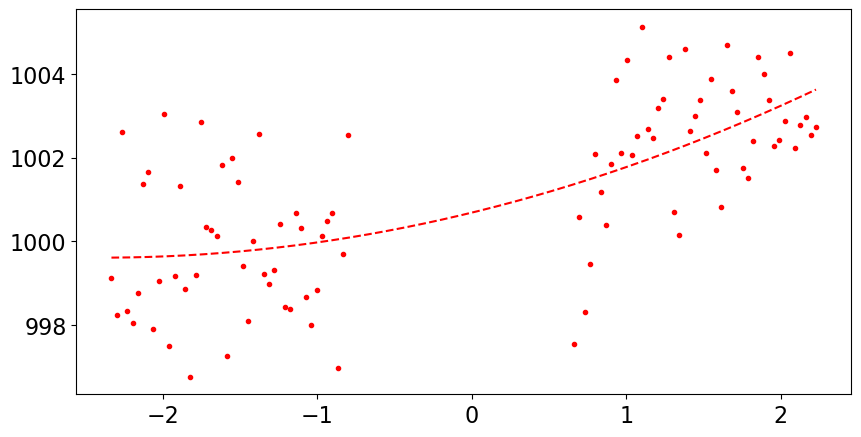

In [44]:
plt.figure(figsize=(10, 5))
plt.plot((data1_fold*24)[~oot_mask1], data1['flux'][~oot_mask1], ".r", label="data1", zorder=-1000)
x_plot_B = np.linspace(np.min(x_oot_B), np.max(x_oot_B), 1000)
plt.plot(x_plot_B, pol_B(x_plot_B), color="r", linestyle="--")


In [45]:
x_conc_B = data1_fold*24
y_conc_B = (data1['flux']/pol_B(data1_fold*24)-1)*1e3
yerr_conc_B = data1['flux_err']

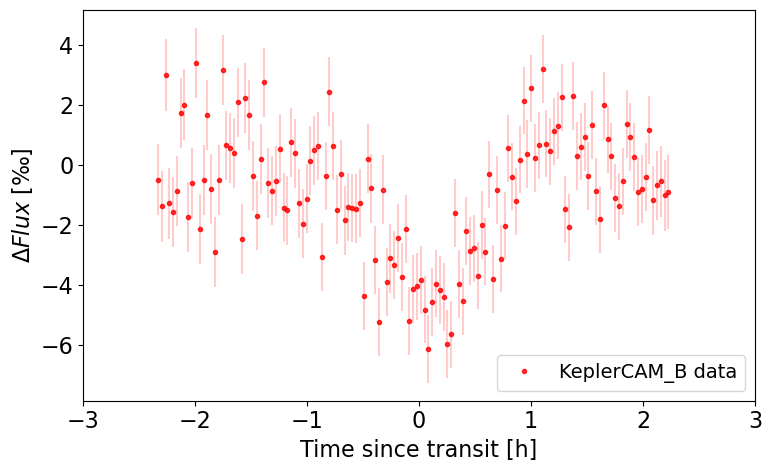

In [46]:
#replot dividing by polynomial
plt.figure(figsize=(8, 5))
# Plot the data
plt.plot(x_conc_B, y_conc_B, 'o', ms=3, color='r', 
         label='KeplerCAM_B data', zorder=1000, alpha=0.8)
plt.errorbar(x_conc_B, y_conc_B, yerr=yerr_conc_B, 
             fmt="none", color='r', capsize=0, zorder=-1000, alpha=0.2)
plt.legend(fontsize=14, loc=4)
plt.xlim(-3,3)
plt.ylabel(u'$\Delta Flux$ [‰]')
plt.xlabel("Time since transit [h]")
plt.tight_layout()
#plt.savefig('new_phot_1199_keplercam.png',dpi=300,bbox_inches='tight', facecolor='white')
plt.show()

In [47]:
data1_ = pd.read_table('./data/photom/TOI1273/KEPLERCAM/TIC445859771.01_UT2020.0213_KeplerCam_B.tbl', sep='\s+')
data1_['flux'] = data1_['rel_flux_T1_dn']*1e3
data1_['time'] = data1_['BJD_TDB']-2457000-ref_time
data1_['flux_err'] = data1_['rel_flux_err_T1_dn']*1e3
data1_fold_ = (data1_['time'] - bls_t0 + 0.5 * bls_period) % bls_period - 0.5 * bls_period

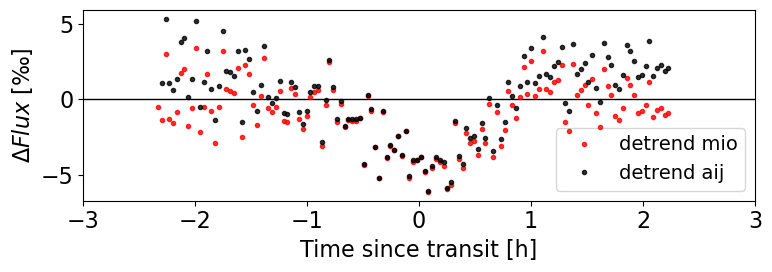

In [48]:
#replot dividing by polynomial
plt.figure(figsize=(8, 3))
# Plot the data
plt.plot(x_conc_B, y_conc_B, 'o', ms=3, color='r', label='detrend mio', zorder=1000, alpha=0.8)
plt.plot(data1_fold_*24, data1_['flux']-1e3, 'o', ms=3, label='detrend aij', color='k', zorder=1000, alpha=0.8)
plt.legend(fontsize=14, loc=4)
# horizontal line at 0
plt.axhline(0, color='k', lw=1)
plt.xlim(-3,3)
plt.ylabel(u'$\Delta Flux$ [‰]')
plt.xlabel("Time since transit [h]")
plt.tight_layout()
#plt.savefig('new_phot_1199_keplercam.png',dpi=300,bbox_inches='tight', facecolor='white')
plt.show()

In [49]:
# datos de keplercam finales
x_keplercam_B = np.ascontiguousarray(data1['time'], dtype=np.float64)
y_keplercam_B = np.ascontiguousarray(y_conc_B, dtype=np.float64)
yerr_keplercam_B = np.ascontiguousarray(yerr_conc_B, dtype=np.float64)

### Muscat

In [50]:
data2 = pd.read_table('./data/photom/TOI1273/MUSCAT/TOI1273-01_20200218_zs_TCS_MuSCAT2_Detrended.dat', names=['BJD_TDB', 'flux', 'flux_err'], sep='\s+')
data3 = pd.read_table('./data/photom/TOI1273/MUSCAT/TOI1273-01_20200218_g_TCS_MuSCAT2_Detrended.dat', names=['BJD_TDB', 'flux', 'flux_err'], sep='\s+')
data4 = pd.read_table('./data/photom/TOI1273/MUSCAT/TOI1273-01_20200218_i_TCS_MuSCAT2_Detrended.dat', names=['BJD_TDB', 'flux', 'flux_err'], sep='\s+')
data5 = pd.read_table('./data/photom/TOI1273/MUSCAT/TOI1273-01_20200218_r_TCS_MuSCAT2_Detrended.dat', names=['BJD_TDB', 'flux', 'flux_err'], sep='\s+')
# Convert time to the same reference time as tess and flux to ppt
data2['bjd'] = data2['BJD_TDB']-2457000-ref_time
data3['bjd'] = data3['BJD_TDB']-2457000-ref_time
data4['bjd'] = data4['BJD_TDB']-2457000-ref_time
data5['bjd'] = data5['BJD_TDB']-2457000-ref_time

data2['flux'] = np.ascontiguousarray(1e3 * (data2['flux'] - 1.0), dtype=np.float64) 
data3['flux'] = np.ascontiguousarray(1e3 * (data3['flux'] - 1.0), dtype=np.float64) 
data4['flux'] = np.ascontiguousarray(1e3 * (data4['flux'] - 1.0), dtype=np.float64) 
data5['flux'] = np.ascontiguousarray(1e3 * (data5['flux'] - 1.0), dtype=np.float64) 

data2['flux_err'] = np.ascontiguousarray(1e3 * (data2['flux_err']), dtype=np.float64) 
data3['flux_err'] = np.ascontiguousarray(1e3 * (data3['flux_err']), dtype=np.float64) 
data4['flux_err'] = np.ascontiguousarray(1e3 * (data4['flux_err']), dtype=np.float64) 
data5['flux_err'] = np.ascontiguousarray(1e3 * (data5['flux_err']), dtype=np.float64) 

In [51]:
print(len(data2), len(data3), len(data4), len(data5))

1772 1771 1772 1770


In [52]:
# Texp?
print(np.median(np.diff(data2['bjd']))*24*60*60)
texp_muscat = None

9.049759805202484


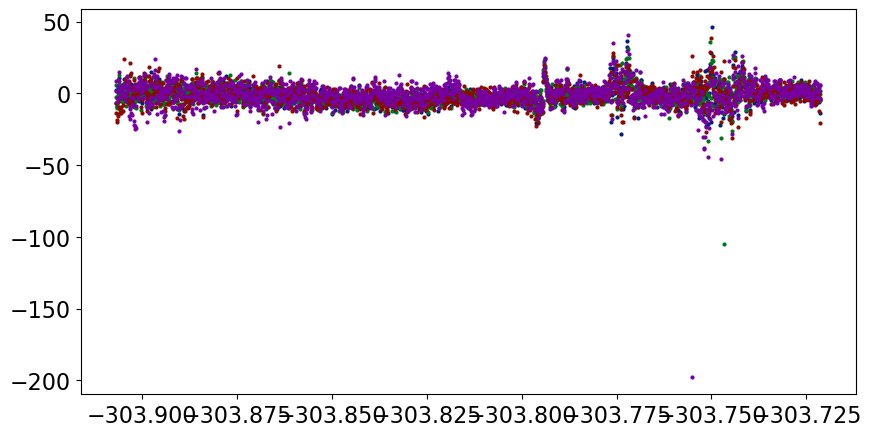

In [53]:
plt.figure(figsize=(10, 5))
plt.plot(data2.bjd, data2.flux, 'o', label='z', ms=2)
plt.plot(data3.bjd, data3.flux, 'o', label='z', ms=2)
plt.plot(data4.bjd, data4.flux, 'o', label='z', ms=2)
plt.plot(data5.bjd, data5.flux, 'o', label='z', ms=2)
plt.show()

In [54]:
# remove outliers 
data2 = data2[np.abs(data2.flux - np.median(data2.flux)) < 3 * np.std(data2.flux)]
data3 = data3[np.abs(data3.flux - np.median(data3.flux)) < 3 * np.std(data3.flux)]
data4 = data4[np.abs(data4.flux - np.median(data4.flux)) < 3 * np.std(data4.flux)]
data5 = data5[np.abs(data5.flux - np.median(data5.flux)) < 3 * np.std(data5.flux)]

In [55]:
print(len(data2), len(data3), len(data4), len(data5))

1746 1748 1747 1756


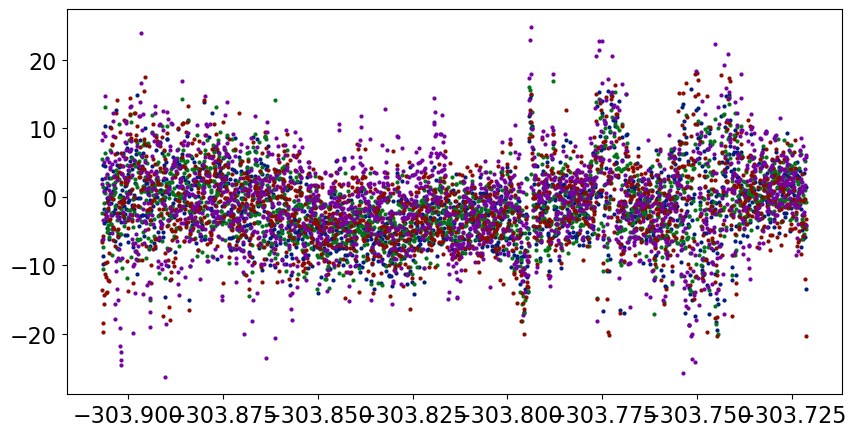

In [56]:
plt.figure(figsize=(10, 5))
plt.plot(data2.bjd, data2.flux, 'o', label='zs', ms=2)
plt.plot(data3.bjd, data3.flux, 'o', label='g', ms=2)
plt.plot(data4.bjd, data4.flux, 'o', label='i', ms=2)
plt.plot(data5.bjd, data5.flux, 'o', label='r', ms=2)
plt.show()

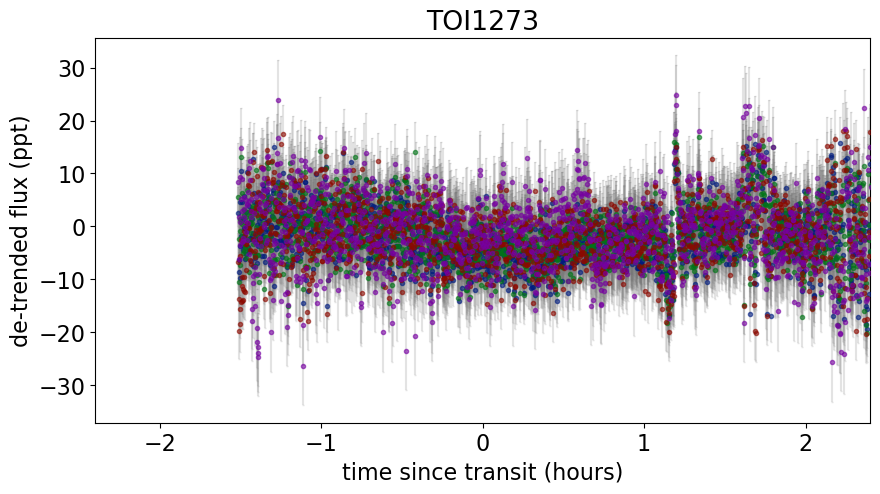

In [57]:
# Plot the folded data, con los parametros del BLS
data2_fold = (data2['bjd'] - bls_t0 + 0.5 * bls_period) % bls_period - 0.5 * bls_period
data3_fold = (data3['bjd'] - bls_t0 + 0.5 * bls_period) % bls_period - 0.5 * bls_period
data4_fold = (data4['bjd'] - bls_t0 + 0.5 * bls_period) % bls_period - 0.5 * bls_period
data5_fold = (data5['bjd'] - bls_t0 + 0.5 * bls_period) % bls_period - 0.5 * bls_period

muscat_time = pd.concat([data2_fold, data3_fold, data4_fold, data5_fold], ignore_index=True)
# datos finales muscat
x_muscat_zs_ = np.ascontiguousarray(data2['bjd'], dtype=np.float64)
x_muscat_g_ = np.ascontiguousarray(data3['bjd'], dtype=np.float64)
x_muscat_i_ = np.ascontiguousarray(data4['bjd'], dtype=np.float64)
x_muscat_r_ = np.ascontiguousarray(data5['bjd'], dtype=np.float64)
y_muscat_zs_ = np.ascontiguousarray(data2['flux'], dtype=np.float64)
y_muscat_g_ = np.ascontiguousarray(data3['flux'], dtype=np.float64)
y_muscat_i_ = np.ascontiguousarray(data4['flux'], dtype=np.float64)
y_muscat_r_ = np.ascontiguousarray(data5['flux'], dtype=np.float64)
yerr_muscat_zs_ = np.ascontiguousarray(data2['flux_err'], dtype=np.float64)
yerr_muscat_g_ = np.ascontiguousarray(data3['flux_err'], dtype=np.float64)
yerr_muscat_i_ = np.ascontiguousarray(data4['flux_err'], dtype=np.float64)
yerr_muscat_r_ = np.ascontiguousarray(data5['flux_err'], dtype=np.float64)

plt.figure(figsize=(10, 5))
plt.plot(data2_fold*24, y_muscat_zs_, '.', label='Muscat2_zs', alpha=0.6, zorder=100)
plt.errorbar(data2_fold*24, y_muscat_zs_, yerr=yerr_muscat_zs_, fmt="none", alpha=0.2, color='#777777', capsize=1, zorder=-100)
plt.plot(data3_fold*24, y_muscat_g_, '.', label='Muscat2_g', alpha=0.6, zorder=100)
plt.errorbar(data3_fold*24, y_muscat_g_, yerr=yerr_muscat_g_, fmt="none", alpha=0.2, color='#777777', capsize=1, zorder=-100)
plt.plot(data4_fold*24, y_muscat_i_, '.', label='Muscat2_i', alpha=0.6, zorder=100)
plt.errorbar(data4_fold*24, y_muscat_i_, yerr=yerr_muscat_i_, fmt="none", alpha=0.2, color='#777777', capsize=1, zorder=-100)
plt.plot(data5_fold*24, y_muscat_r_, '.', label='Muscat2_r', alpha=0.6, zorder=100)
plt.errorbar(data5_fold*24, y_muscat_r_, yerr=yerr_muscat_r_, fmt="none", alpha=0.2, color='#777777', capsize=1, zorder=-100)

plt.ylabel("de-trended flux (ppt)")
plt.xlabel('time since transit (hours)')
plt.xlim(-0.10*24, 0.10*24)
plt.title("TOI1273")
#plt.savefig('new_phot_1199.png',dpi=200,bbox_inches='tight', facecolor='white')
plt.show()

In [58]:
# mask the second half of the transit?
x_muscat_zs = x_muscat_zs_[data2_fold*24<0.5]
x_muscat_g = x_muscat_g_[data3_fold*24<0.5]
x_muscat_i = x_muscat_i_[data4_fold*24<0.5]
x_muscat_r = x_muscat_r_[data5_fold*24<0.5]
y_muscat_zs = y_muscat_zs_[data2_fold*24<0.5]
y_muscat_g = y_muscat_g_[data3_fold*24<0.5]
y_muscat_i = y_muscat_i_[data4_fold*24<0.5]
y_muscat_r = y_muscat_r_[data5_fold*24<0.5]
yerr_muscat_zs = yerr_muscat_zs_[data2_fold*24<0.5]
yerr_muscat_g = yerr_muscat_g_[data3_fold*24<0.5]
yerr_muscat_i = yerr_muscat_i_[data4_fold*24<0.5]
yerr_muscat_r = yerr_muscat_r_[data5_fold*24<0.5]

print(len(x_muscat_zs), len(y_muscat_zs), len(yerr_muscat_zs))
print(len(x_muscat_g), len(y_muscat_g), len(yerr_muscat_g))
print(len(x_muscat_i), len(y_muscat_i), len(yerr_muscat_i))
print(len(x_muscat_r), len(y_muscat_r), len(yerr_muscat_r))

801 801 801
801 801 801
798 798 798
801 801 801


# LC dataset

In [59]:
from collections import OrderedDict

datasets = OrderedDict(
    [
        ("tess_2min", [x, y, yerr, texp]),
        ("tess_30min", [xlong, ylong, yerrlong, texp_long]),
        ("keplercam_B", [x_keplercam_B, y_keplercam_B, yerr_keplercam_B, texp_keplercam]),
        ('muscat_g', [x_muscat_g, y_muscat_g, yerr_muscat_g, texp_muscat]),
        ('muscat_r', [x_muscat_r, y_muscat_r, yerr_muscat_r, texp_muscat]),
        ('muscat_i', [x_muscat_i, y_muscat_i, yerr_muscat_i, texp_muscat]),
        ('muscat_zs', [x_muscat_zs, y_muscat_zs, yerr_muscat_zs, texp_muscat]),
    ]
)

In [60]:
# print type of all arrays in datasets
for n, (name, (x_, y_, yerr_, texp_)) in enumerate(datasets.items()):
    print(n, name, len(x_), len(y_), len(yerr_), type(x_), type(y_), type(yerr_))

0 tess_2min 3530 3530 3530 <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
1 tess_30min 38 38 38 <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
2 keplercam_B 135 135 135 <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
3 muscat_g 801 801 801 <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
4 muscat_r 801 801 801 <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
5 muscat_i 798 798 798 <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
6 muscat_zs 801 801 801 <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


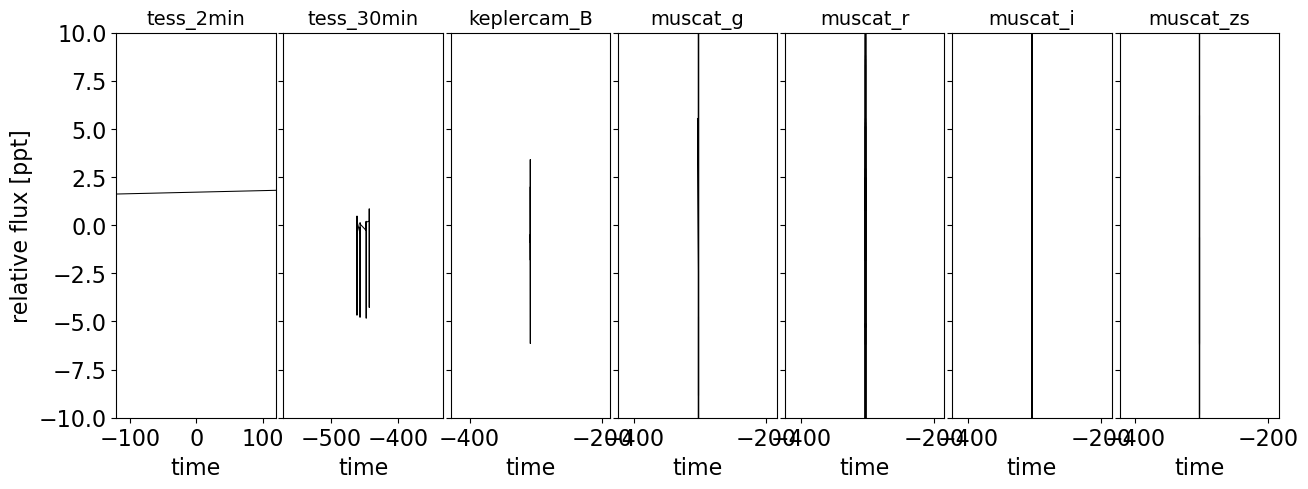

In [61]:
fig, axes = plt.subplots(1, len(datasets), sharey=True, figsize=(15, 5))

for i, (name, (t, y, _, _)) in enumerate(datasets.items()):
    ax = axes[i]
    ax.plot(t, y, "k", lw=0.75, label=name)
    ax.set_xlabel("time")
    ax.set_title(name, fontsize=14)

    x_mid = 0.5 * (t.min() + t.max())
    ax.set_xlim(x_mid - 120, x_mid + 120)
axes[0].set_ylim(-10, 10)
fig.subplots_adjust(wspace=0.05)
_ = axes[0].set_ylabel("relative flux [ppt]")

In [62]:
K = xo.estimate_semi_amplitude(bls_period, x_rv, y_rv, yerr_rv, t0s=bls_t0)
print(K, "m/s")

[26.47708999] m/s


In [63]:
K.item()

26.477089986851546

In [64]:
0.5*np.log(spoc_depth * 1e-3)

-2.663358420534867

# Joint model

In [65]:
# These arrays are used as the times/phases where the models are
# evaluated at higher resolution for plotting purposes 
t_rv = np.linspace(x_rv.min() - 5, x_rv.max() + 5, 3000)
phase_lc = np.linspace(-0.3, 0.3, 500)

for i in range(10):
    with pm.Model() as model:
        # Parameters for the stellar properties
        BoundedNormal = pm.Bound(pm.Normal, lower=0, upper=3)
        m_star = BoundedNormal("m_star", mu=M_star[0], sd=M_star[1])
        r_star = BoundedNormal("r_star", mu=R_star[0], sd=R_star[1])

        # Orbital parameters for the planets
        t0 = pm.Normal("t0", mu=bls_t0, sd=1)
        log_period = pm.Normal("log_period", mu=np.log(bls_period), sd=1)

        # b = pmx.UnitUniform("b")
        log_ror = pm.TruncatedNormal("log_ror", mu=0.5*np.log(spoc_depth * 1e-3), sd=1, upper=np.log(0.1675))
        #log_ror = pm.Normal("log_ror", mu=0.5*np.log(spoc_depth * 1e-3), sd=1)
        ror = pm.Deterministic("ror", tt.exp(log_ror))
        r_pl = pm.Deterministic("r_pl", ror * r_star)
        b = xo.ImpactParameter("b", ror)

        logK = pm.Normal("logK", mu=np.log(K.item()), sd=2.0)
        K = pm.Deterministic("K", tt.exp(logK))
        #m_pl = pm.Deterministic("m_pl", tt.exp(log_m_pl))
        period = pm.Deterministic("period", tt.exp(log_period))

        # comentar las proximas tres lineas para versión con e=0 fixed
        ecs = pmx.UnitDisk("ecs", testval=np.array([0.01, 0.01]))
        ecc = pm.Deterministic("ecc", tt.sum(ecs**2))
        omega = pm.Deterministic("omega", tt.arctan2(ecs[1], ecs[0]))

        # RV jitter & a quadratic RV trend
        log_sigma_rv = pm.Normal("log_sigma_rv", mu=np.log(np.median(yerr_rv)), sd=1)
        trend = pm.Normal("trend", mu=0, sd=10.0 ** -np.arange(3)[::-1], shape=3)  # [2,1,0]

        # Orbit model
        orbit = xo.orbits.KeplerianOrbit(
            r_star=r_star,
            m_star=m_star,
            period=period,
            t0=t0,
            b=b,
            ecc=ecc,
            omega=omega,
        )

        # Loop over the instruments
        parameters = dict()
        lc_models = dict()
        transit_obs = dict()
        lc_pred = dict()
        # The light curve model
        def lc_model(mean, star, r_pl, texp, t):
            return tt.sum((star.get_light_curve(orbit=orbit, r=r_pl, t=t, texp=texp)*1e3), axis=-1) + mean

        for n, (name, (x_, y_, yerr_, texp_)) in enumerate(datasets.items()):
            # We define the per-instrument parameters in a submodel so that we
            # don't have to prefix the names manually
            with pm.Model(name=name, model=model):
                # The flux zero point
                mean = pm.Normal("mean", mu=0.0, sd=5.0)
                # The limb darkening
                # both tess datasets should share the same limb darkening coefficients
                if "tess_30min" in name:
                    star = xo.LimbDarkLightCurve(u_star)
                else:
                    u_star = xo.QuadLimbDark("u_star")
                    star = xo.LimbDarkLightCurve(u_star)
                    
                # Transit jitter
                logs = pm.Normal("logs", mu=np.log(np.median(yerr_)), sd=1)
                
                # Keep track of the parameters for optimization
                parameters[name] = [mean, u_star, logs]

            #lc_model = partial(lc_model, mean, star, ror, texp)
            lc_models[name] = lc_model(mean, star, r_pl, texp_, x_)

            # The likelihood for the light curve
            err_lc = tt.sqrt(yerr_**2 + tt.exp(2*logs)) 
            transit_obs = pm.Normal(f"{name}_obs", mu=lc_models[name], sd=err_lc, observed=y_) 

            # # Compute and save the phased light curve models
            pm.Deterministic(f"{name}_lc_pred", tt.sum(star.get_light_curve(orbit=orbit, r=r_pl, t=t0+phase_lc, texp=texp_)*1e3, axis=-1))

        # And a function for computing the full RV model
        def get_rv_model(t, name=""):
            # First the RVs induced by the planet
            vrad = orbit.get_radial_velocity(t, K=tt.exp(logK))
            pm.Deterministic("vrad" + name, vrad)

            # Define the background model
            A = np.vander(t - x_ref, 3) # Generate a Vandermonde matrix with t-x_ref as input vector
            bkg = pm.Deterministic("bkg" + name, tt.dot(A, trend))

            # Sum planet and background to get the full model
            return pm.Deterministic("rv_model" + name, vrad + bkg)


        # Define the model
        rv_model = get_rv_model(x_rv)
        get_rv_model(t_rv, name="_pred")

        # The likelihood for the RVs
        err = tt.sqrt(yerr_rv**2 + tt.exp(2 * log_sigma_rv))
        pm.Normal("obs", mu=rv_model, sd=err, observed=y_rv)

        # Optimize the model
        map_soln = model.test_point
        for name in datasets:
            map_soln = pmx.optimize(map_soln, parameters[name])
        for name in datasets:
            map_soln = pmx.optimize(map_soln, parameters[name] + [logK, ecs, b, log_period])
            map_soln = pmx.optimize(map_soln, parameters[name] + [log_sigma_rv, trend])
        map_soln = pmx.optimize(map_soln)

        extras = dict()
        for name in datasets:
            extras[name] = pmx.eval_in_model(lc_models[name], map_soln)

        # Do some sigma clipping
        num = dict((name, len(datasets[name][0])) for name in datasets)
        clipped = dict()
        masks = dict()
        for name in datasets:
            mdl = pmx.eval_in_model(lc_models[name], map_soln)
            resid = datasets[name][1] - mdl
            sigma = np.sqrt(np.median((resid - np.median(resid)) ** 2))
            masks[name] = np.abs(resid - np.median(resid)) < 7 * sigma
            clipped[name] = num[name] - masks[name].sum()
            print(f"Sigma clipped {clipped[name]} {name} light curve points")

        if all(c < 10 for c in clipped.values()):
            break

        else:
            for name in datasets:
                datasets[name][0] = datasets[name][0][masks[name]]
                datasets[name][1] = datasets[name][1][masks[name]]
                datasets[name][2] = datasets[name][2][masks[name]]

optimizing logp for variables: [tess_2min_logs, tess_2min_u_star, tess_2min_mean]


message: Desired error not necessarily achieved due to precision loss.
logp: -21097.417008404565 -> -19645.303769539867
optimizing logp for variables: [tess_30min_logs, tess_2min_u_star, tess_30min_mean]


message: Optimization terminated successfully.
logp: -19645.303769539867 -> -19343.80006421658
optimizing logp for variables: [keplercam_B_logs, keplercam_B_u_star, keplercam_B_mean]


message: Optimization terminated successfully.
logp: -19343.80006421658 -> -19224.02583777098
optimizing logp for variables: [muscat_g_logs, muscat_g_u_star, muscat_g_mean]


message: Optimization terminated successfully.
logp: -19224.025837770983 -> -19053.664316691677
optimizing logp for variables: [muscat_r_logs, muscat_r_u_star, muscat_r_mean]


message: Optimization terminated successfully.
logp: -19053.664316691677 -> -18905.853021258517
optimizing logp for variables: [muscat_i_logs, muscat_i_u_star, muscat_i_mean]


message: Optimization terminated successfully.
logp: -18905.853021258517 -> -18803.848444210176
optimizing logp for variables: [muscat_zs_logs, muscat_zs_u_star, muscat_zs_mean]


message: Optimization terminated successfully.
logp: -18803.848444210176 -> -18667.173340269295
optimizing logp for variables: [log_period, b, log_ror, ecs, logK, tess_2min_logs, tess_2min_u_star, tess_2min_mean]


message: Desired error not necessarily achieved due to precision loss.
logp: -18667.173340269295 -> -17532.101184963605
optimizing logp for variables: [trend, log_sigma_rv, tess_2min_logs, tess_2min_u_star, tess_2min_mean]


message: Desired error not necessarily achieved due to precision loss.
logp: -17532.101184963605 -> -17518.219548377456
optimizing logp for variables: [log_period, b, log_ror, ecs, logK, tess_30min_logs, tess_2min_u_star, tess_30min_mean]


message: Desired error not necessarily achieved due to precision loss.
logp: -17518.219548377456 -> -17440.756476560327
optimizing logp for variables: [trend, log_sigma_rv, tess_30min_logs, tess_2min_u_star, tess_30min_mean]


message: Desired error not necessarily achieved due to precision loss.
logp: -17440.756476560327 -> -17400.613181877612
optimizing logp for variables: [log_period, b, log_ror, ecs, logK, keplercam_B_logs, keplercam_B_u_star, keplercam_B_mean]


message: Desired error not necessarily achieved due to precision loss.
logp: -17400.613181877612 -> -17350.858018142444
optimizing logp for variables: [trend, log_sigma_rv, keplercam_B_logs, keplercam_B_u_star, keplercam_B_mean]


message: Desired error not necessarily achieved due to precision loss.
logp: -17350.858018142444 -> -17350.587697056715
optimizing logp for variables: [log_period, b, log_ror, ecs, logK, muscat_g_logs, muscat_g_u_star, muscat_g_mean]


message: Desired error not necessarily achieved due to precision loss.
logp: -17350.587697056715 -> -17302.398276897475
optimizing logp for variables: [trend, log_sigma_rv, muscat_g_logs, muscat_g_u_star, muscat_g_mean]


message: Optimization terminated successfully.
logp: -17302.398276897475 -> -17302.38882778214
optimizing logp for variables: [log_period, b, log_ror, ecs, logK, muscat_r_logs, muscat_r_u_star, muscat_r_mean]


message: Desired error not necessarily achieved due to precision loss.
logp: -17302.38882778214 -> -17280.959593127616
optimizing logp for variables: [trend, log_sigma_rv, muscat_r_logs, muscat_r_u_star, muscat_r_mean]


message: Desired error not necessarily achieved due to precision loss.
logp: -17280.959593127616 -> -17280.93756226204
optimizing logp for variables: [log_period, b, log_ror, ecs, logK, muscat_i_logs, muscat_i_u_star, muscat_i_mean]


message: Desired error not necessarily achieved due to precision loss.
logp: -17280.93756226204 -> -17251.08823709997
optimizing logp for variables: [trend, log_sigma_rv, muscat_i_logs, muscat_i_u_star, muscat_i_mean]


message: Optimization terminated successfully.
logp: -17251.08823709997 -> -17251.08599101522
optimizing logp for variables: [log_period, b, log_ror, ecs, logK, muscat_zs_logs, muscat_zs_u_star, muscat_zs_mean]


message: Desired error not necessarily achieved due to precision loss.
logp: -17251.08599101522 -> -17170.19978053918
optimizing logp for variables: [trend, log_sigma_rv, muscat_zs_logs, muscat_zs_u_star, muscat_zs_mean]


message: Optimization terminated successfully.
logp: -17170.199780539184 -> -17170.17927160258
optimizing logp for variables: [muscat_zs_logs, muscat_zs_u_star, muscat_zs_mean, muscat_i_logs, muscat_i_u_star, muscat_i_mean, muscat_r_logs, muscat_r_u_star, muscat_r_mean, muscat_g_logs, muscat_g_u_star, muscat_g_mean, keplercam_B_logs, keplercam_B_u_star, keplercam_B_mean, tess_30min_logs, tess_30min_mean, tess_2min_logs, tess_2min_u_star, tess_2min_mean, trend, log_sigma_rv, ecs, logK, b, log_ror, log_period, t0, r_star, m_star]


message: Desired error not necessarily achieved due to precision loss.
logp: -17170.179271602578 -> -16616.71378039483


Sigma clipped 1 tess_2min light curve points
Sigma clipped 0 tess_30min light curve points
Sigma clipped 0 keplercam_B light curve points
Sigma clipped 0 muscat_g light curve points
Sigma clipped 0 muscat_r light curve points
Sigma clipped 0 muscat_i light curve points
Sigma clipped 0 muscat_zs light curve points


MAP rv model

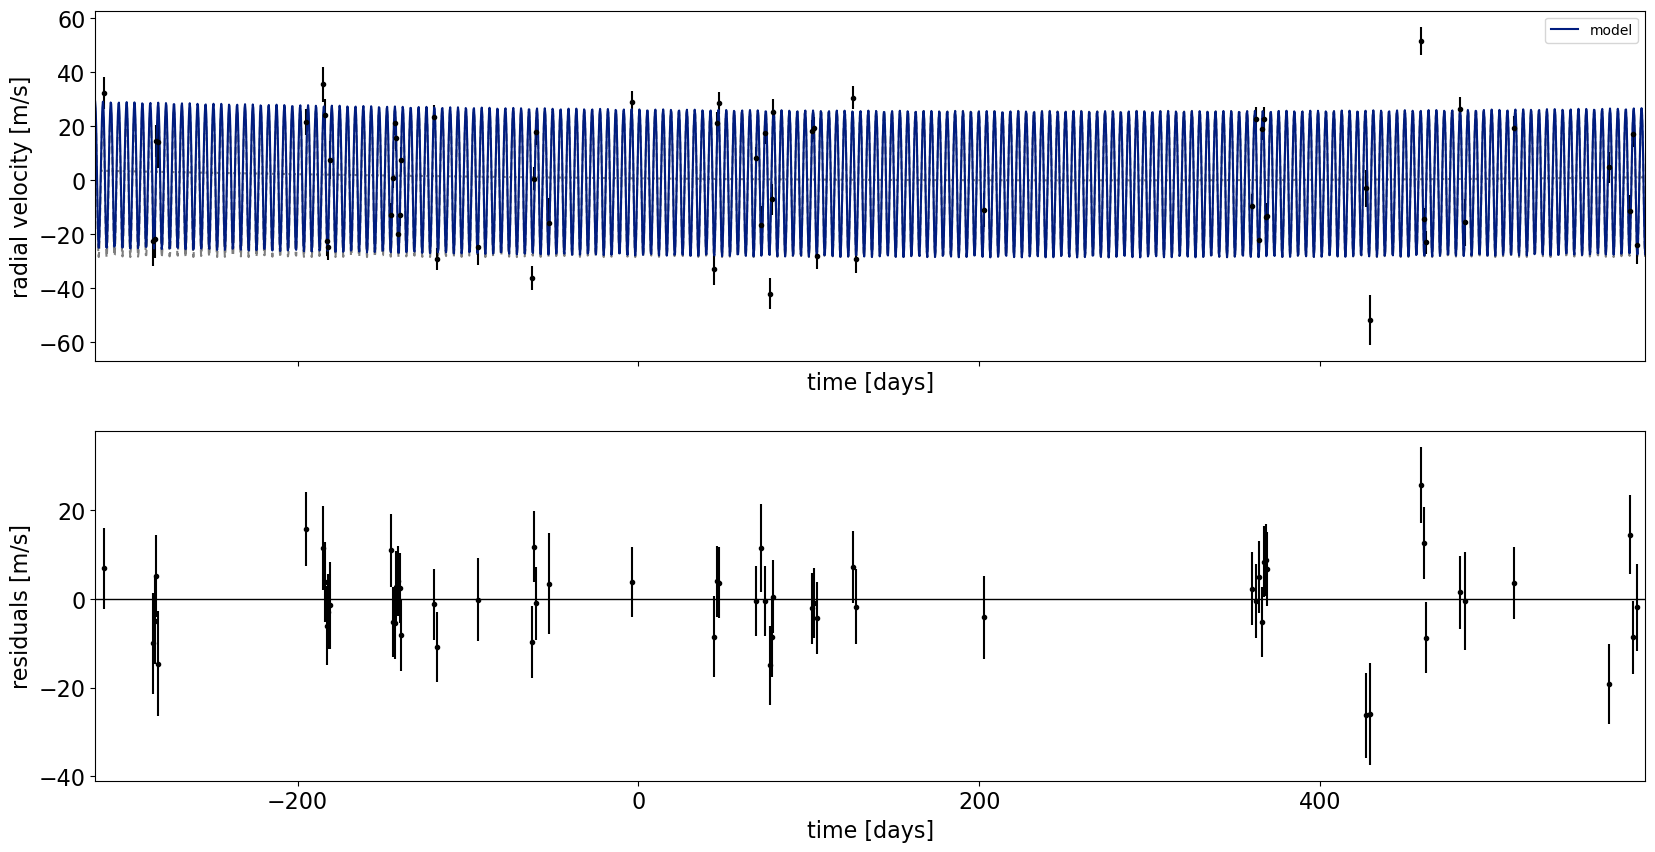

In [66]:
# We plot the initial model:
def plot_rv_curve(soln):
    fig, axes = plt.subplots(2, 1, figsize=(20, 10), sharex=True)
    ax = axes[0]
    ax.errorbar(x_rv, y_rv, yerr=yerr_rv, fmt=".k")
    ax.plot(t_rv, soln['vrad_pred'], "--k", alpha=0.5)
    ax.plot(t_rv, soln['bkg_pred'], ":k", alpha=0.5)
    ax.plot(t_rv, soln['rv_model_pred'], label="model")
    ax.legend(fontsize=10)
    ax.set_xlabel("time [days]")
    ax.set_ylabel("radial velocity [m/s]")
    
    ax = axes[1]
    err = np.sqrt(yerr_rv**2 + np.exp(2 * soln["log_sigma_rv"]))
    ax.errorbar(x_rv, y_rv - soln["rv_model"], yerr=err, fmt=".k")
    ax.axhline(0, color="k", lw=1)
    ax.set_ylabel("residuals [m/s]")
    ax.set_xlim(t_rv.min(), t_rv.max())
    #ax.set_xlim(2200,2300)
    ax.set_xlabel("time [days]")

_ = plot_rv_curve(map_soln)

In [67]:
datasets.keys()

odict_keys(['tess_2min', 'tess_30min', 'keplercam_B', 'muscat_g', 'muscat_r', 'muscat_i', 'muscat_zs'])

MAP LCs models

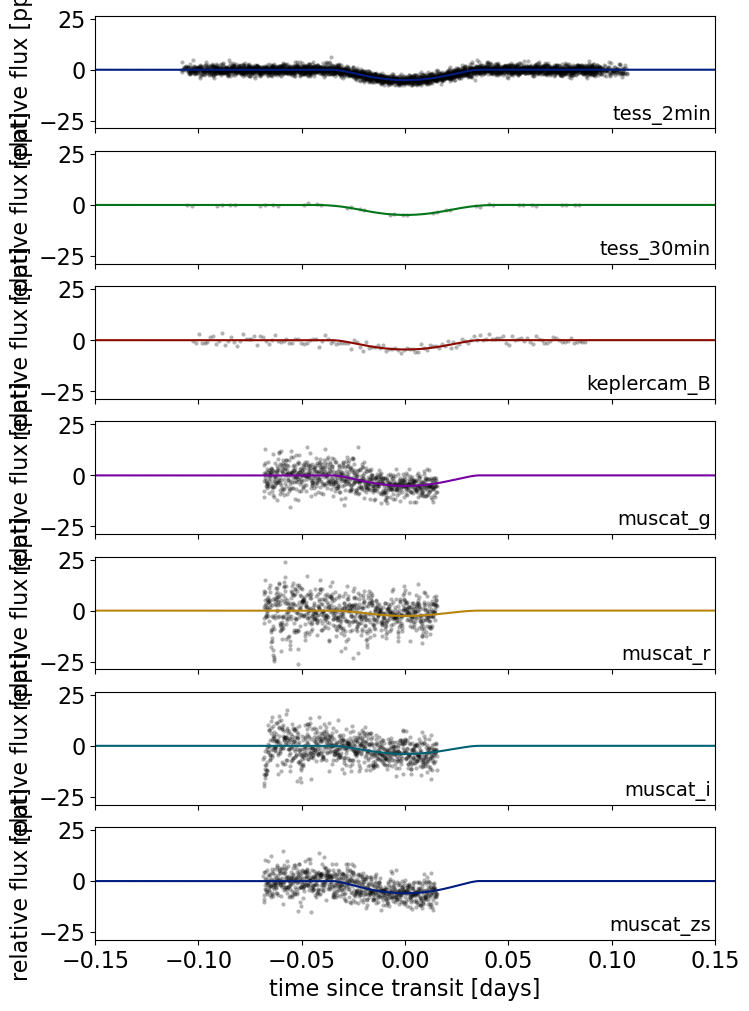

In [68]:
fig, axes = plt.subplots(7, sharex=True, sharey=True, figsize=(8, 12))

for n, name in enumerate(datasets):
    ax = axes[n]

    x, y = datasets[name][:2]

    period = map_soln["period"]
    folded = (x - map_soln["t0"] + 0.5 * period) % period - 0.5 * period
    m = np.abs(folded) < 0.2
    ax.plot(
        folded[m],
        (y  - map_soln[f"{name}_mean"])[m],
        ".k",
        alpha=0.3,
        mec="none",
    )
    ax.plot(
        phase_lc, map_soln[name+'_lc_pred'], f"C{n}", label=name
    ) 
    ax.annotate(
        name,
        xy=(1, 0),
        xycoords="axes fraction",
        va="bottom",
        ha="right",
        xytext=(-3, 3),
        textcoords="offset points",
        fontsize=14,
    )

axes[-1].set_xlim(-0.15, 0.15)
axes[-1].set_xlabel("time since transit [days]")
for ax in axes:
    ax.set_ylabel("relative flux [ppt]")

#plt.savefig('lcs_fits.png', dpi=200, bbox_inches='tight')

In [69]:
# pm.model_to_graphviz(model)

# Sampling

In [70]:
# with model:
#     trace = pmx.sample(
#         tune=4000, #2500,
#         draws=4000, #2000,
#         start=map_soln,
#         cores=4, #4
#         chains=2, #4
#         target_accept=0.95,
#         return_inferencedata=True,
#         random_seed=[203771098, 203775000],#, 261136679, 261136680],
#         init="adapt_full",
#     )

In [71]:
import arviz as az
# version con e libre
#az.to_netcdf(trace, 'trace.toi1273_glcs_1radio_conK_30min_noprior.save')
trace = az.from_netcdf('trace.toi1273_glcs_1radio_conK_30min.save')

# version con e=0 fixed
# az.to_netcdf(trace, 'trace.toi1273_noecc.save')
# trace = az.from_netcdf('trace.toi1273_noecc.save')

In [72]:
#trace.posterior.data_vars
# print only the names
#trace=trace_
for n, var in enumerate(trace.posterior.data_vars):
    if n>15:
        print(n, var)

16 muscat_i_logs
17 muscat_zs_mean
18 muscat_zs_logs
19 m_star
20 r_star
21 log_ror
22 ror
23 r_pl
24 b
25 K
26 period
27 ecs
28 ecc
29 omega
30 tess_2min_u_star
31 tess_2min_lc_pred
32 tess_30min_lc_pred
33 keplercam_B_u_star
34 keplercam_B_lc_pred
35 muscat_g_u_star
36 muscat_g_lc_pred
37 muscat_r_u_star
38 muscat_r_lc_pred
39 muscat_i_u_star
40 muscat_i_lc_pred
41 muscat_zs_u_star
42 muscat_zs_lc_pred
43 vrad
44 bkg
45 rv_model
46 vrad_pred
47 bkg_pred
48 rv_model_pred


Summary stats

In [73]:
summary= az.summary(trace, stat_funcs={'median': np.median, 'std':np.std}, hdi_prob=0.997, round_to=6,
           var_names=[
               't0',
               'logK',
               'log_period',
               'log_ror',
               'log_sigma_rv',
               'trend',
               'tess_2min_mean',
               'tess_2min_logs',
               'tess_30min_mean',
               'tess_30min_logs',
               'keplercam_B_mean',
               'keplercam_B_logs',
               'muscat_zs_mean',
               'muscat_zs_logs',
               'muscat_g_mean',
               'muscat_g_logs',
               'muscat_i_mean',
               'muscat_i_logs',
               'muscat_r_mean',
               'muscat_r_logs',
               'm_star',
               'r_star',
               'ror',
               'r_pl',
               'b',
               'K',
               'period',
               'ecs',
               'ecc',
               'omega',
               'tess_2min_u_star',
               'keplercam_B_u_star',
               'muscat_zs_u_star',
               'muscat_g_u_star',
               'muscat_i_u_star',
               'muscat_r_u_star',
           ])

In [74]:
print(summary.ess_bulk.mean())
print(summary.ess_tail.mean())

6993.952067244445
4832.393588955555


In [75]:
summary

,mean,sd,hdi_0.15%,hdi_99.85%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,median,std
t0,-489.090103,0.000432,-489.091453,-489.088903,0.000005,0.000003,7940.747836,6113.623924,0.999862,-489.090095,0.000432
logK,3.286573,0.058085,3.112487,3.450237,0.000612,0.000433,9067.551193,5476.794921,1.000527,3.287289,0.058081
log_period,1.532837,0.000001,1.532835,1.532839,0.000000,0.000000,9011.571624,5551.471379,1.000962,1.532837,0.000001
log_ror,-2.270595,0.155417,-2.530901,-1.804462,0.004951,0.003502,1178.984422,638.573012,1.002427,-2.301939,0.155407
log_sigma_rv,2.000657,0.150327,1.572270,2.435864,0.001653,0.001169,8297.867615,6407.410083,0.999882,2.003925,0.150317
trend[0],0.000010,0.000015,-0.000034,0.000055,0.000000,0.000000,9505.402140,5495.492305,1.000408,0.000010,0.000015
trend[1],-0.002833,0.004475,-0.016460,0.011212,0.000047,0.000044,9261.092773,5523.230483,1.000040,-0.002889,0.004475
trend[2],0.053509,0.875528,-2.581408,2.647205,0.009099,0.009889,9262.709459,5641.979914,1.000530,0.045364,0.875473
tess_2min_mean,0.090646,0.030813,-0.002231,0.181369,0.000303,0.000238,10359.120147,5490.947438,1.000201,0.090551,0.030811
tess_2min_logs,-2.246548,0.433620,-3.753288,-1.254953,0.005054,0.003892,8874.233580,4389.430007,1.000218,-2.199831,0.433593


array([<Axes: title={'center': 'r_pl'}>, <Axes: title={'center': 'b'}>,
       <Axes: title={'center': 'ecc'}>], dtype=object)

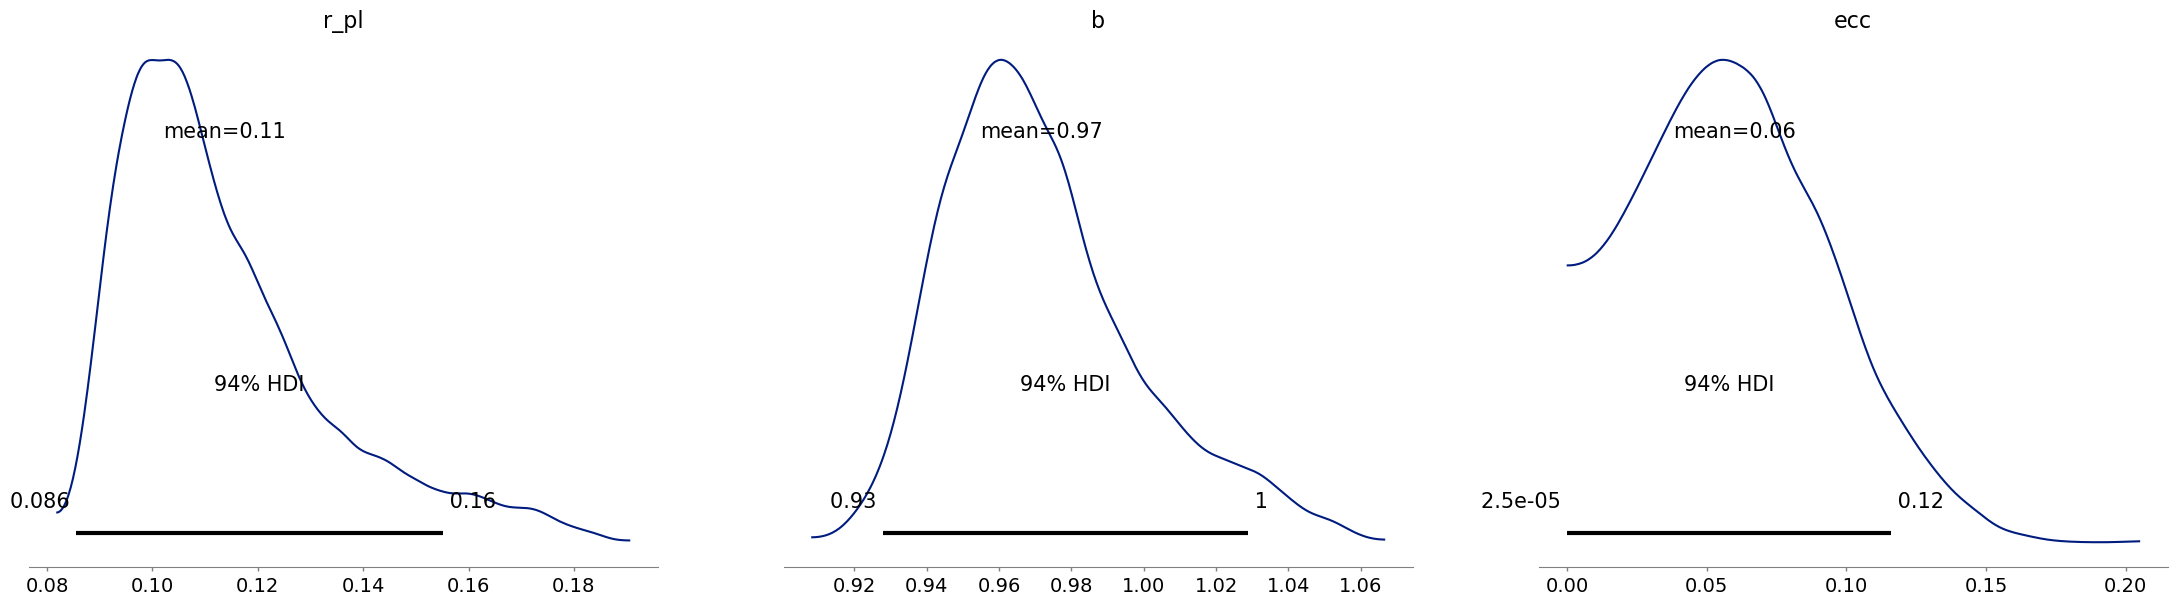

In [76]:
az.plot_posterior(trace, var_names=['r_pl', 'b', 'ecc'])
#plt.savefig('posterior.png', dpi=300, bbox_inches='tight')

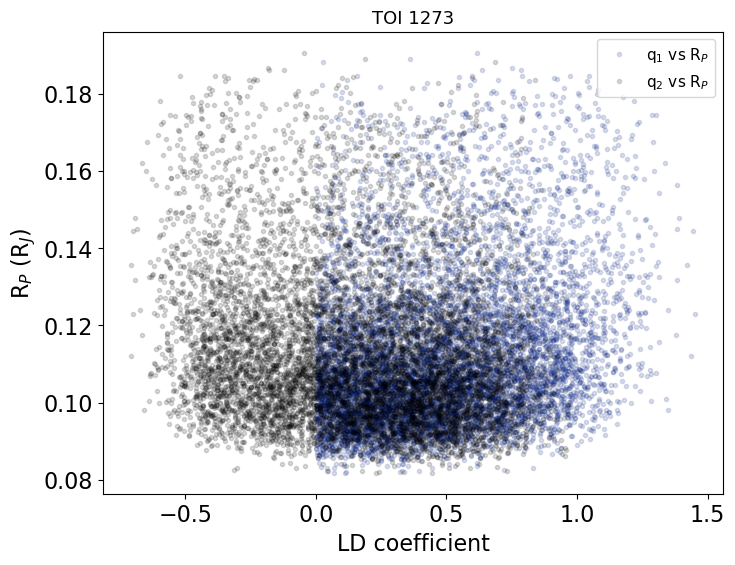

In [79]:
#plot limb darkening coefficient vs radius
plt.plot(trace.posterior["tess_2min_u_star"].stack(sample=("chain", "draw"))[0],
        trace.posterior["r_pl"].stack(draws=("chain", "draw")),'.',alpha=0.15, label="q$_1$ vs R$_P$")
plt.plot(trace.posterior["tess_2min_u_star"].stack(sample=("chain", "draw"))[1],
        trace.posterior["r_pl"].stack(draws=("chain", "draw")),'.k',alpha=0.15, label="q$_2$ vs R$_P$")
plt.legend(loc='best', fontsize=11)
plt.xlabel("LD coefficient")
plt.ylabel("R$_P$ (R$_J$)")
plt.title("TOI 1273", fontsize=13)
plt.savefig("toi1273_ld_vs_rp.png", dpi=300, bbox_inches='tight')

Parametros

In [82]:
import math
from uncertainties import ufloat
from uncertainties.umath import *

radio = ufloat((trace.posterior["r_pl"].median().item()*u.R_sun).to(u.R_jup).value, (trace.posterior["r_pl"].std().item()*u.R_sun).to(u.R_jup).value)
b = ufloat(trace.posterior["b"].median().item(), trace.posterior["b"].std().item())
K = ufloat(trace.posterior["K"].median().item(), trace.posterior["K"].std().item())
eccen = ufloat(trace.posterior["ecc"].median().item(), trace.posterior["ecc"].std().item())
omega = ufloat(trace.posterior["omega"].median().item(), trace.posterior["omega"].std().item())
periodo = ufloat(trace.posterior['period'].median().item()*u.day.to(u.second),trace.posterior['period'].std().item()*u.day.to(u.second))
t_0 = ufloat(trace.posterior['t0'].median().item()+ref_time, trace.posterior['t0'].std().item())
mstar = ufloat(trace.posterior['m_star'].median().item()*u.M_sun.to(u.kg), trace.posterior['m_star'].std().item()*u.M_sun.to(u.kg))
rstar = ufloat(trace.posterior['r_star'].median().item()*u.R_sun.to(u.au), trace.posterior['r_star'].std().item()*u.R_sun.to(u.au))

print("Rp = {r:.3f} Rj".format(r=radio))
print("b = {b:.3f}".format(b=b))
print("e = {e:.6f}".format(e=eccen))
print("omega = {w:.6f}".format(w=omega))
print("P = {p:.6f} days".format(p=periodo*u.second.to(u.day)))
print("Epoca = {e:.5f}".format(e=t_0))
print('K = {k:.3f} m/s'.format(k=K))

Rp = 1.055+/-0.195 Rj
b = 0.967+/-0.027
e = 0.057792+/-0.033769
omega = 2.180291+/-2.175095
P = 4.631296+/-0.000003 days
Epoca = 1712.34678+/-0.00043
K = 26.770+/-1.551 m/s


In [83]:
from scipy import constants
G = constants.G
# paso a numpy los que necesito para calcular otros parámetros
K_posterior = trace.posterior['K'].stack(sample=("chain", "draw")).to_numpy()
eccen_posterior = trace.posterior['ecc'].stack(sample=("chain", "draw")).to_numpy()
periodo_posterior = trace.posterior['period'].stack(sample=("chain", "draw")).to_numpy()*u.day.to(u.second)
mstar_posterior = trace.posterior['m_star'].stack(sample=("chain", "draw")).to_numpy()*u.M_sun.to(u.kg)
rstar_posterior = trace.posterior['r_star'].stack(sample=("chain", "draw")).to_numpy()
radio_posterior = trace.posterior['r_pl'].stack(sample=("chain", "draw")).to_numpy()*u.R_sun.to(u.cm)
# calculo los parámetros que me interesan
mpl_posterior = K_posterior*np.sqrt(1-eccen_posterior**2)*(periodo_posterior*mstar_posterior**2/(2*np.pi*G))**(1/3)*u.kg.to(u.M_jup)
mpl = ufloat(np.median(mpl_posterior),np.std(mpl_posterior))
density_posterior = mpl_posterior*u.M_jup.to(u.g)/(4/3*np.pi*radio_posterior**3)
densidad = ufloat(np.median(density_posterior),np.std(density_posterior))
teff = 5697
a_posterior = (periodo_posterior**2*G*(mstar_posterior+mpl_posterior*u.Mjup.to(u.kg))/(4*np.pi**2))**(1/3)*u.m.to(u.au)
a = ufloat(np.median(a_posterior), np.std(a_posterior))
teq_posterior = teff*(rstar_posterior*u.Rsun.to(u.au)/a_posterior)**(1/2)*(1/4)**(1/4)
teq = ufloat(np.median(teq_posterior),np.std(teq_posterior))

print('densidad = {d:.3f} g/cm^3'.format(d=densidad))
print('a = {s:.4f} au'.format(s=a))
print('Teq = {t:.3f} K'.format(t=teq))
print('m_pl = {m:.3f} Mj'.format(m=mpl))

densidad = 0.227+/-0.098 g/cm^3
a = 0.0540+/-0.0004 au
Teq = 1232.297+/-16.091 K
m_pl = 0.216+/-0.013 Mj


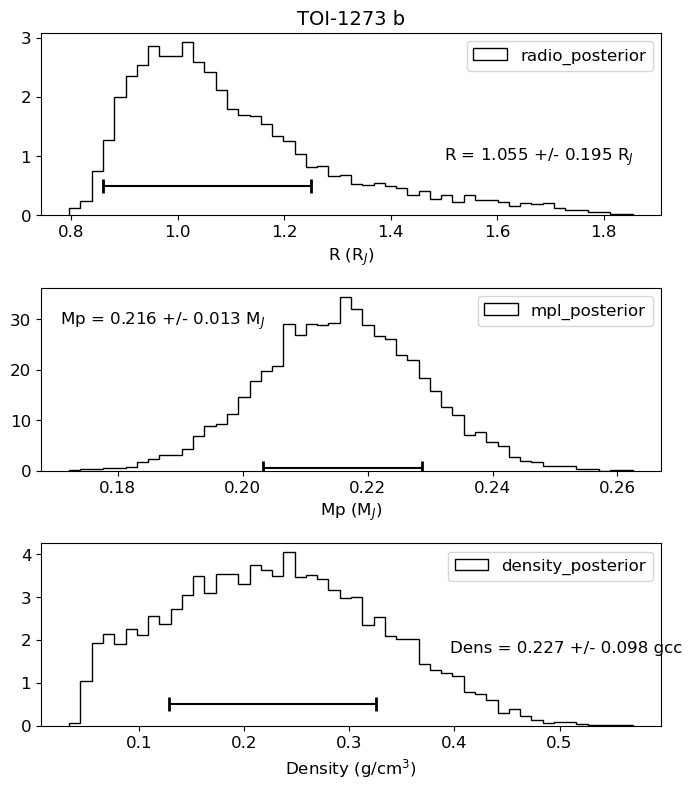

In [122]:
# in the same plot show two histograms of radio_posterior and mpl_posterior
fig, ax = plt.subplots(3, figsize=(8, 9))
fig.subplots_adjust(hspace=0.4)
ax[0].set_title('TOI-1273 b', fontsize=14)
ax[0].hist(radio_posterior*u.cm.to(u.Rjup), bins=50, density=True, histtype='step', color='k', label='radio_posterior')
ax[1].hist(mpl_posterior, bins=50, density=True,histtype='step', color='k', label='mpl_posterior')
ax[2].hist(density_posterior, bins=50, density=True,histtype='step', color='k', label='density_posterior')
ax[0].legend(fontsize=12)
ax[1].legend(fontsize=12)
ax[2].legend(fontsize=12)
ax[0].set_xlabel('R (R$_J$)', fontsize=12)
ax[1].set_xlabel('Mp (M$_J$)', fontsize=12)
ax[2].set_xlabel('Density (g/cm$^3$)', fontsize=12)
for i in range(3):
    ax[i].tick_params(labelsize=12)
# add the median and 1-sigma error bars at the top left
ax[0].errorbar(np.median(radio_posterior*u.cm.to(u.Rjup)), 0.5, xerr=np.std(radio_posterior*u.cm.to(u.Rjup)), color='k', capsize=5, capthick=2)
ax[1].errorbar(np.median(mpl_posterior), 0.5, xerr=np.std(mpl_posterior), color='k', capsize=5, capthick=2)
ax[2].errorbar(np.median(density_posterior), 0.5, xerr=np.std(density_posterior), color='k', capsize=5, capthick=2)
# show the numbers in the plot
ax[0].text(0.65, 0.3, 'R = {:.3f} +/- {:.3f} R$_J$'.format(np.median(radio_posterior*u.cm.to(u.Rjup)), np.std(radio_posterior*u.cm.to(u.Rjup))), transform=ax[0].transAxes, fontsize=12)
ax[1].text(0.03, 0.8, 'Mp = {:.3f} +/- {:.3f} M$_J$'.format(np.median(mpl_posterior), np.std(mpl_posterior)), transform=ax[1].transAxes, fontsize=12)
ax[2].text(0.66, 0.4, 'Dens = {:.3f} +/- {:.3f} gcc'.format(np.median(density_posterior), np.std(density_posterior)), transform=ax[2].transAxes, fontsize=12)

#plt.savefig('posterior_density_1273.png', dpi=300, bbox_inches='tight', facecolor='w')
plt.show()

In [86]:
from uncertainties import ufloat
from uncertainties.umath import *

logsigma_rv_mean = trace.posterior["log_sigma_rv"].mean().item()
logsigma_rv = ufloat(logsigma_rv_mean, trace.posterior["log_sigma_rv"].std().item())
rv_jitter_ = np.e**logsigma_rv
# tess_jitter_median = trace.posterior['logs'].median().item()
# tess_jitter = ufloat(tess_jitter_median, trace.posterior['logs'].std().item())
# tess_jitter_val = np.e**tess_jitter
tess_2min_jitter_median = trace.posterior['tess_2min_logs'].median().item()
tess_2min_jitter = ufloat(tess_2min_jitter_median, trace.posterior['tess_2min_logs'].std().item())
tess_2min_jitter_val = np.e**tess_2min_jitter
tess_30min_jitter_median = trace.posterior['tess_30min_logs'].median().item()
tess_30min_jitter = ufloat(tess_30min_jitter_median, trace.posterior['tess_30min_logs'].std().item())
tess_30min_jitter_val = np.e**tess_30min_jitter
keplercam_B_jitter_median = trace.posterior['keplercam_B_logs'].median().item()
keplercam_B_jitter = ufloat(keplercam_B_jitter_median, trace.posterior['keplercam_B_logs'].std().item())
keplercam_B_jitter_val = np.e**keplercam_B_jitter
muscat_zs_jitter_median = trace.posterior['muscat_zs_logs'].median().item()
muscat_zs_jitter = ufloat(muscat_zs_jitter_median, trace.posterior['muscat_zs_logs'].std().item())
muscat_zs_jitter_val = np.e**muscat_zs_jitter
# same for g, i, r
muscat_g_jitter_median = trace.posterior['muscat_g_logs'].median().item()
muscat_g_jitter = ufloat(muscat_g_jitter_median, trace.posterior['muscat_g_logs'].std().item())
muscat_g_jitter_val = np.e**muscat_g_jitter
muscat_i_jitter_median = trace.posterior['muscat_i_logs'].median().item()
muscat_i_jitter = ufloat(muscat_i_jitter_median, trace.posterior['muscat_i_logs'].std().item())
muscat_i_jitter_val = np.e**muscat_i_jitter
muscat_r_jitter_median = trace.posterior['muscat_r_logs'].median().item()
muscat_r_jitter = ufloat(muscat_r_jitter_median, trace.posterior['muscat_r_logs'].std().item())
muscat_r_jitter_val = np.e**muscat_r_jitter
print("RV jitter = ", rv_jitter_)
print("TESS 2min jitter = ", tess_2min_jitter_val)
print("TESS 30min jitter = ", tess_30min_jitter_val)
print("Keplercam B jitter = ", keplercam_B_jitter_val)
print("Muscat zs jitter = ", muscat_zs_jitter_val)
print("Muscat g jitter = ", muscat_g_jitter_val)
print("Muscat i jitter = ", muscat_i_jitter_val)
print("Muscat r jitter = ", muscat_r_jitter_val)

RV jitter =  7.4+/-1.1
TESS 2min jitter =  0.11+/-0.05
TESS 30min jitter =  0.10+/-0.06
Keplercam B jitter =  0.82+/-0.17
Muscat zs jitter =  0.46+/-0.21
Muscat g jitter =  0.46+/-0.20
Muscat i jitter =  1.2+/-0.5
Muscat r jitter =  0.8+/-0.4


In [ ]:
from arviz.utils import Numba
Numba.disable_numba()
Numba.numba_flag

_ = az.plot_trace(trace, var_names=['r_pl', 'K','ecc', 'b'] #log_depth or log_ror
                                    , compact=False, figsize=(12,20)) # SAMPLED 1 #ror instead of log_depth
# _ = az.plot_trace(trace, var_names=['log_period', 'log_m_pl', 't0', 'r_star', 'm_star']
#                                    , compact=False, figsize=(12,20)) # SAMPLED 2
# _ = az.plot_trace(trace, var_names=['ecs', 'b', 'u_star', 'mean']
#                                    , compact=False, figsize=(12,25)) # SAMPLED 3
# plt.savefig('trace_joint_1199_1.png',dpi=200,bbox_inches='tight')

In [ ]:
trace3 = trace.copy()
trace3.posterior['r_pl'] = trace3.posterior['r_pl']*9.73116
trace3.posterior['t0'] = trace3.posterior['t0']+2457000+ref_time

## Cornerplot

In [ ]:
CORNER_KWARGS = dict(
    smooth=0.5,
    plot_density=True,
    plot_datapoints=True,
    fill_contours=False,
    #levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.)),
    levels=(0.16,0.5,0.84),
    max_n_ticks=3
)

In [ ]:
from cProfile import label
import corner
plt.figure(figsize=(14,14))
# figure = corner.corner(trace3, var_names=['m_pl', 'r_pl', 'b', 'ecc', 'omega'],#, 'omega'], 
#                         labels=[r"$M_P ~(M_\oplus)$", r"$R_P ~(R_{J})$", r"$b$", r"$e$", r"$\omega$ (rad)"], label_kwargs={'fontsize':20},#, r"$\omega$ (rad)"],
#                         show_titles=True, title_kwargs={'fontsize':20, 'pad':9.0}, titles=['$M_P$','$R_P$','$b$','$e$', '$\omega$'], divergences=True, plot_contours=True,
#                         labelpad=0, color='C2', quantiles=[0.16, 0.5, 0.84], **CORNER_KWARGS) #, quantiles=[0.16, 0.5, 0.84],
figure = corner.corner(trace3, var_names=['period', 't0', 'K', 'r_pl', 'b', 'ecc', 'omega', 'm_star', 'r_star'],
                        labels=["P (d)","T$_0$ (BJD)","K (m s$^{-1}$)", "R$_P$ (R$_J$)", "b", "e", "$\omega~$(rad)","M$_\star$ (M$_\odot$)","R$_\star$ (R$_\odot$)"], label_kwargs={'fontsize':20},
                        show_titles=False, title_kwargs={'fontsize':20, 'pad':9.0}, titles=['P', 'T\_0', 'K','R\_P','b','e','$\omega$','M\_$\star$','R\_$\star$'], divergences=True, plot_contours=True,
                        labelpad=0.2, color='k', **CORNER_KWARGS)
for ax in figure.get_axes():
    ax.tick_params(axis='both', pad=1, direction='in', labelbottom=True, labelleft=True, left=True, bottom=True)
#plt.savefig('corner_1273_paper.png',dpi=300,bbox_inches='tight', facecolor='w')
plt.show()

## LC Phase plot

In [ ]:
colormap1 = ['#FFEE58', '#FFEE58', '#5C6BC0', '#4FC3F7', '#FFB74D', '#FF8A65', '#F44336', '#A1887F']

In [ ]:
flat_samps = trace.posterior.stack(sample=("chain", "draw"))

# Get the posterior median orbital parameters
p_ = np.median(flat_samps["period"])
p_err = np.std(flat_samps["period"])
t0_ = np.median(flat_samps["t0"])
t0_err = np.std(flat_samps["t0"])
tess_2min_mean = np.median(flat_samps["tess_2min_mean"])
tess_30min_mean = np.median(flat_samps["tess_30min_mean"])
keplercam_B_mean = np.median(flat_samps["keplercam_B_mean"])
muscat_zs_mean = np.median(flat_samps["muscat_zs_mean"])
muscat_r_mean = np.median(flat_samps["muscat_r_mean"])
muscat_g_mean = np.median(flat_samps["muscat_g_mean"])
muscat_i_mean = np.median(flat_samps["muscat_i_mean"])

In [ ]:
fig, axes = plt.subplots(7, sharex=True, sharey=True, figsize=(8, 10))
plt.subplots_adjust(hspace=0.0)
# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("Time since transit [h]")
plt.ylabel(u'$\Delta Flux$ [‰]')
for n, name in enumerate(datasets):
    ax = axes[n]
    # plot the folded transits
    x, y, yerr = datasets[name][:3]
    folded = (x - t0_ + 0.5 * p_) % p_ - 0.5 * p_
    mean = np.median(flat_samps[f"{name}_mean"])
    ax.plot(folded*24, (y  - mean), marker='o', ls='none', color=colormap1[n], 
            mec=colormap1[n], mew=1, alpha=1, label=f"{name}", ms=5, zorder=8)
    ax.errorbar(folded*24, (y  - mean), yerr=yerr, fmt='o', color=colormap1[n],
                alpha=0.8, ms=5, zorder=8, elinewidth=0.5, capsize=0)
    # Overplot the phase binned light curve with rmse as error bars
    lcc = lk.LightCurve(time=folded, flux=y - mean, flux_err=yerr)
    lcc_binned = lcc.bin(time_bin_size=0.01)
    ax.scatter(lcc_binned['time'].value*24, lcc_binned['flux'].value, marker='o', s=30,  
               edgecolors='w', linewidths=0.5, c='k', alpha=0.9, zorder=12)
    # overplot the model
    pred = np.percentile(flat_samps[f"{name}_lc_pred"], [16, 50, 84], axis=-1)
    #ax.plot(phase_lc*24, pred[1], color="k", linewidth=1, alpha=1, zorder=11) #f"C{n+1}"
    art = ax.fill_between(phase_lc*24, pred[0], pred[2], color="w", alpha=1, zorder=10)
    art.set_edgecolor("k")
    ax.legend(fontsize=11, loc=4, frameon=False, handlelength=0.8, handletextpad=0.5, 
              borderpad=0.5, markerscale=0)#,  prop={"family":"sans-serif", 'weight':'light'})
    ax.tick_params(axis='y', which='major', size=4, left=True, right=True, direction='in', labelsize=13)
    ax.tick_params(axis='y', which='minor', size=2, left=True, right=True, direction='in', labelsize=13)
    ax.tick_params(axis='x', which='major', size=4, bottom=False, top=False, direction='in', labelsize=13)
    if n==5:
        ax.tick_params(axis='x', which='major', size=2, bottom=True, top=False, direction='in', labelsize=13)

axes[-1].set_xlim(-0.07*24, 0.07*24)
axes[-1].set_ylim(-10, 5)

#plt.savefig('1273_lcsfit.png', dpi=300, bbox_inches='tight')
plt.show()

## RV Phase plot

In [ ]:
rv_jitter = np.exp(np.median(flat_samps['log_sigma_rv']))
bkg_ = np.median(flat_samps['bkg'].values, axis=-1)
rv_model_ = np.median(flat_samps['rv_model'].values, axis=-1)

# Plot the folded data
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True, gridspec_kw={'height_ratios': [3,1]})
x_fold = (x_rv - t0_ + 0.5 * p_) % p_ - 0.5 * p_
ax1.errorbar(x_fold/p_, y_rv - bkg_, yerr=np.sqrt(yerr_rv**2+rv_jitter**2), fmt="o", color='#FBC15E', 
            markeredgecolor='k', ecolor='k', elinewidth=1, label='SOPHIE data', alpha=0.8)

# Compute the posterior prediction for the folded RV model 
t_fold = (t_rv - t0_ + 0.5 * p_) % p_ - 0.5 * p_
inds = np.argsort(t_fold)
pred = np.percentile(trace.posterior["vrad_pred"].values[:, :, inds],[16, 50, 84],axis=(0, 1),)
ax1.plot(t_fold[inds]/p_, pred[1], color="#988ED5", label="RV Model")
art = ax1.fill_between(t_fold[inds]/p_, pred[0], pred[2], color="#988ED5", alpha=0.5)
art.set_edgecolor("none")

ax1.set_xlim(-0.51, 0.51)
ax1.set_ylabel("RV [$m~s^{-1}$]")
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles[::-1], labels[::-1], fontsize=14, loc='best')

# Plot the folded residuals
ax2.axhline(y=0, ls='--', color='k', linewidth=1, alpha=0.5)
ax2.errorbar(x_fold/p_, y_rv-rv_model_, yerr=np.sqrt(yerr_rv**2+rv_jitter**2), fmt="o", color='#FBC15E',
            markeredgecolor='k', ecolor='k', elinewidth=1, alpha=0.8, label='residuals')
ax2.set_ylabel('Residuals', labelpad=8)
ax2.set_xlabel("Phase")
ax2.set_xlim(-0.51, 0.51)
ax2.set_xticks([-0.5, 0, 0.5])
ax2.set_yticks([-40,-20, 0, 20, 40])
plt.tight_layout()
#plt.savefig('1273_rvs_fit.png', dpi=300, bbox_inches='tight', facecolor='white')

### Periodograms with residues

In [ ]:
ls_res = LombScargle(data.bjd, y_rv-rv_model_)
frequency_res, power_res = ls_res.autopower(minimum_frequency=0.001, maximum_frequency=2, samples_per_peak=5)
faps_res = ls_res.false_alarm_level(probabilities)  

In [ ]:
from matplotlib.ticker import ScalarFormatter
# plot two figures in a column
fig, axes = plt.subplots(4, 1, sharex=True, sharey=True, figsize=(7, 6))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0)
axes[0].plot(1/frequency, power, color='k', lw=0.5, zorder=10) 
axes[1].plot(1/frequency_res, power_res, color='k', lw=0.5, zorder=10)
axes[2].plot(1/frequency_bis, power_bis, color='k', lw=0.5, zorder=10) 
#axes[3].plot(1/frequency_window, power_window,  color='k', lw=0.8, zorder=10)
axes[3].plot(prange, wf, color='r', lw=0.5, zorder=10)

# plot the 'bls_period' as a vertical line behind the plot and show in legend
axes[0].axvline(p_, ls='-', lw=1.5, alpha=0.7, color='deepskyblue', label='Transit period', zorder=-10)
axes[1].axvline(p_, ls='-', lw=1.5, alpha=0.7, color='deepskyblue', label='', zorder=-10)
axes[2].axvline(p_, ls='-', lw=1.5, alpha=0.7, color='deepskyblue', label='', zorder=-10)
axes[3].axvline(p_, ls='-', lw=1.5, alpha=0.7, color='deepskyblue', label='', zorder=-10)
# add the aliases as red dashed vertical lines
for i in range(4):
    if i==0:
        axes[i].axvline(aliases[0], lw=1.5, alpha=0.7, ls='dotted', color='deepskyblue', label='1d aliases')
        axes[i].axvline(aliases[2], lw=1.5, alpha=0.7, ls='dotted', color='deepskyblue')
    else:
        axes[i].axvline(aliases[0], lw=1.5, alpha=0.7, ls='dotted', color='deepskyblue', label='')
        axes[i].axvline(aliases[2], lw=1.5, alpha=0.7, ls='dotted', color='deepskyblue')

# overplot the false alarm probabilities
names2 = [faps, faps_res, faps_bis]
for i, names in enumerate(names2):
    # axes[i].axhline(names[0], ls='--', lw=1, alpha=0.8, color='lightgray', label='10% FAP', zorder=-20)
    # axes[i].axhline(names[1], ls='--', lw=1, alpha=0.8, color='darkgray', label='5% FAP', zorder=-20)
    if i==0:
        axes[i].axhline(names[2], ls='dashed', lw=1, alpha=0.8, color='dimgray', label='1% FAP', zorder=-20)
    else:
        axes[i].axhline(names[2], ls='dashed', lw=1, alpha=0.8, color='dimgray', label='', zorder=-20)

axes[0].set_xlim(0.6, 1000)
axes[0].set_ylim(0, 1.1)
axes[0].set_xscale('log')
axes[1].set_xscale('log')
axes[2].set_xscale('log')
axes[3].set_xscale('log')

axes[0].legend(loc='upper right', title='RVs', frameon=False, prop=dict(family='serif', weight='normal', size=8), title_fontsize=10)
axes[1].legend(loc='upper right', title='Residuals', frameon=False, prop=dict(family='serif', weight='normal', size=8), title_fontsize=10)
axes[2].legend(loc='upper right', title='BIS', frameon=False, prop=dict(family='serif', weight='normal', size=8), title_fontsize=10)
axes[3].legend(loc='upper right', title='Window function', frameon=False, prop=dict(family='serif', weight='normal', size=8), title_fontsize=10)
axes[0].tick_params(axis='both', which='major', size=4, top=True, right=True, direction='inout', labelsize=10)
axes[1].tick_params(axis='both', which='major', size=4, top=True, right=True, direction='inout', labelsize=10)
axes[2].tick_params(axis='both', which='major', size=4, top=True, right=True, direction='inout', labelsize=10)
axes[3].tick_params(axis='both', which='major', size=4, top=True, right=True, direction='inout', labelsize=10)
axes[0].tick_params(axis='both', which='minor', size=2, top=True, right=True, direction='inout', labelsize=10)
axes[1].tick_params(axis='both', which='minor', size=2, top=True, right=True, direction='inout', labelsize=10)
axes[2].tick_params(axis='both', which='minor', size=2, top=True, right=True, direction='inout', labelsize=10)
axes[3].tick_params(axis='both', which='minor', size=2, top=True, right=True, direction='inout', labelsize=10)
axes[0].set_yticks([0.2,  0.4, 0.6, 0.8, 1.0])
# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("Period (d)", labelpad=-5, fontsize=11)
plt.ylabel("Power", labelpad=-1, fontsize=11)
axes[0].text(0.57, 0.83, 'TOI-1273 b', transform=axes[0].transAxes, fontsize=10, ha='right', fontweight='semibold', fontfamily='serif',
             bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round', pad=0.1, lw=0, alpha=0.8))

formatter = ScalarFormatter()
axes[3].xaxis.set_major_formatter(formatter)
#plt.savefig('periodograms_1273.png', dpi=400, bbox_inches='tight', facecolor='white')
#plt.show()


## FIT figure paper

In [ ]:
def format_axes(fig):
    for i, ax in enumerate(fig.axes):
        ax.tick_params(axis='both', which='major', size=3, left=True, right=True, top=True, bottom=True, direction='in', labelsize=11)
        ax.tick_params(axis='both', which='minor', size=1.5, left=True, right=True, top=True, bottom=True, direction='in', labelsize=11)
# format_axes(fig)

In [ ]:
fig = plt.figure(figsize=(14, 9), constrained_layout=False)
outer_grid = fig.add_gridspec(6, 4, wspace=0.5, hspace=0.5)

inner_grid1 = outer_grid[0:2, 0:2].subgridspec(1, 2, wspace=0)
axs1 = inner_grid1.subplots(sharey=True)

inner_grid2 = outer_grid[2:4, 0:2].subgridspec(1, 2, wspace=0)
axs2 = inner_grid2.subplots()

inner_grid3 = outer_grid[4:6, 0:4].subgridspec(1, 4, wspace=0)
axs3 = inner_grid3.subplots(sharey=True)

inner_grid4 = outer_grid[0:4, 2:4].subgridspec(2, 1, hspace=0, height_ratios=[3, 1])
axs4 = inner_grid4.subplots(sharex=True)

#tess 2 min
x1, y1, yerr1 = datasets['tess_2min'][:3]
x1_fold = (x1 - t0_ + 0.5 * p_) % p_ - 0.5 * p_
# axs1[0].plot(x1_fold*24, y1-tess_2min_mean, marker='o', ls='none', color='lightgrey', 
#             mec='lightgrey', mew=1, alpha=1, label="TESS 2min", ms=4)
axs1[0].errorbar(x1_fold*24, y1-tess_2min_mean, yerr=yerr1, fmt="o", color='lightgrey', 
            mec='darkgrey', mew=0.2, ecolor='darkgrey', elinewidth=0.2, label="TESS 2min", alpha=1, zorder=1, ms=4) 
lcc1 = lk.LightCurve(time=x1_fold, flux=y1-tess_2min_mean, flux_err=yerr1)
lcc1_binned = lcc1.bin(time_bin_size=0.01)
axs1[0].scatter(lcc1_binned['time'].value*24, lcc1_binned['flux'].value, marker='o', s=15,  
                c='k', alpha=0.9, zorder=12)
pred1 = np.percentile(flat_samps["tess_2min_lc_pred"], [16, 50, 84], axis=-1)
axs1[0].plot(phase_lc*24, pred1[1], color='gold', label="model", lw=1.5)
art = axs1[0].fill_between(phase_lc*24, pred1[0], pred1[2], color='gold', alpha=0.5, zorder=2)
art.set_edgecolor("none")
axs1[0].set_xlim(-0.08*24, 0.08*24)
axs1[0].set_ylim(-9, 6)
axs1[0].set_yticks([-8,-4,0,4])
axs1[0].set_ylabel(u'$\Delta$ Flux (‰)', fontsize=12, labelpad=0.5)
axs1[0].set_xlabel("Time (h)", fontsize=12, labelpad=0.5)
axs1[0].text(0.36, 0.9, 'TESS 2-min', transform=axs1[0].transAxes, fontsize=10, ha='right', fontweight='normal', fontfamily='sans-serif',
             bbox=dict(facecolor='white', edgecolor='k', boxstyle='round', pad=0.2, lw=0.5, alpha=0.8))

#tess 30 min
x2, y2, yerr2 = datasets['tess_30min'][:3]
x2_fold = (x2 - t0_ + 0.5 * p_) % p_ - 0.5 * p_
# axs1[1].plot(x2_fold*24, y2-tess_30min_mean, marker='o', ls='none', color='lightgrey',
#             mec='lightgrey', mew=1, alpha=1, label="TESS 30-min", ms=4)
axs1[1].errorbar(x2_fold*24, y2-tess_30min_mean, yerr=yerr2, fmt="o", color='lightgrey', 
            mec='darkgrey', mew=0.2, ecolor='darkgrey', elinewidth=0.2, label="TESS 30-min", alpha=1, zorder=1, ms=4) 
lcc2 = lk.LightCurve(time=x2_fold, flux=y2-tess_30min_mean, flux_err=yerr2)
lcc2_binned = lcc2.bin(time_bin_size=0.02)
axs1[1].scatter(lcc2_binned['time'].value*24, lcc2_binned['flux'].value, marker='o', s=15,
                c='k', alpha=0.9, zorder=12)
pred2 = np.percentile(flat_samps["tess_30min_lc_pred"], [16, 50, 84], axis=-1)
axs1[1].plot(phase_lc*24, pred2[1], color='gold', label="model", lw=1.5)
art = axs1[1].fill_between(phase_lc*24, pred2[0], pred2[2], color='gold', alpha=0.5, zorder=2)
art.set_edgecolor("none")
axs1[1].set_xlim(-0.08*24, 0.08*24)
axs1[1].set_ylim(-9, 6)
axs1[1].set_xlabel("Time (h)", fontsize=12, labelpad=0.5)
axs1[1].text(0.395, 0.9, 'TESS 30-min', transform=axs1[1].transAxes, fontsize=10, ha='right', fontweight='normal', fontfamily='sans-serif',
             bbox=dict(facecolor='white', edgecolor='k', boxstyle='round', pad=0.2, lw=0.5, alpha=0.8))

# keplercam_B
x3, y3, yerr3 = datasets['keplercam_B'][:3]
x3_fold = (x3 - t0_ + 0.5 * p_) % p_ - 0.5 * p_
# axs2[0].plot(x3_fold*24, y3-keplercam_B_mean, marker='o', ls='none', color='lightgrey',
#             mec='lightgrey', mew=1, alpha=1, label="Keplercam B", ms=4)
# axs2[0].errorbar(x3_fold*24, y3-keplercam_B_mean, yerr=yerr3, fmt='o', color=colormap1[2],
#              alpha=0.8, ms=4, zorder=8, elinewidth=0.5, capsize=0)
axs2[0].errorbar(x3_fold*24, y3-keplercam_B_mean, yerr=yerr3, fmt="o", color='lightgrey', 
            mec='darkgrey', mew=0.2, ecolor='darkgrey', elinewidth=0.2, label="Keplercam B", alpha=1, zorder=1, ms=4) 
lcc3 = lk.LightCurve(time=x3_fold, flux=y3-keplercam_B_mean, flux_err=yerr3)
lcc3_binned = lcc3.bin(time_bin_size=0.01)
axs2[0].scatter(lcc3_binned['time'].value*24, lcc3_binned['flux'].value, marker='o', s=15,
                c='k', alpha=0.9, zorder=12)
pred3 = np.percentile(flat_samps["keplercam_B_lc_pred"], [16, 50, 84], axis=-1)
axs2[0].plot(phase_lc*24, pred3[1], color=colormap1[2], label="model", lw=1.5)
art = axs2[0].fill_between(phase_lc*24, pred3[0], pred3[2], color=colormap1[2], alpha=0.5, zorder=2)
art.set_edgecolor("none")
axs2[0].set_xlim(-0.08*24, 0.08*24)
axs2[0].set_ylim(-9, 6)
axs2[0].set_yticks([-8,-4,0,4])
axs2[0].set_ylabel(u'$\Delta$ Flux (‰)', fontsize=12, labelpad=0.5)
axs2[0].set_xlabel("Time (h)", fontsize=12, labelpad=0.5)
axs2[0].text(0.395, 0.9, 'Keplercam B', transform=axs2[0].transAxes, fontsize=10, ha='right', fontweight='normal', fontfamily='sans-serif',
             bbox=dict(facecolor='white', edgecolor='k', boxstyle='round', pad=0.2, lw=0.5, alpha=0.8))

axs2[1].spines['left'].set_visible(True)
axs2[1].spines['right'].set_visible(False)
axs2[1].spines['top'].set_visible(False)
axs2[1].spines['bottom'].set_visible(False)
axs2[1].set_xticks([])
axs2[1].set_yticks([])

# MuSCAT2 g
x4, y4, yerr4 = datasets['muscat_g'][:3]
x4_fold = (x4 - t0_ + 0.5 * p_) % p_ - 0.5 * p_
# axs3[0].plot(x4_fold*24, y4-muscat_g_mean, marker='o', ls='none', color='lightgrey',
#             mec='lightgrey', mew=1, alpha=1, label="MuSCAT2 g", ms=4)
# axs3[0].errorbar(x4_fold*24, y4-muscat_g_mean, yerr=yerr4, fmt='o', color=colormap1[3],
#              alpha=0.8, ms=4, zorder=8, elinewidth=0.5, capsize=0)
axs3[0].errorbar(x4_fold*24, y4-muscat_g_mean, yerr=yerr4, fmt="o", color='lightgrey', 
            mec='darkgrey', mew=0.2, ecolor='darkgrey', elinewidth=0.2, label="MuSCAT2 g", alpha=1, zorder=1, ms=4) 
lcc4 = lk.LightCurve(time=x4_fold, flux=y4-muscat_g_mean, flux_err=yerr4)
lcc4_binned = lcc4.bin(time_bin_size=0.01)
axs3[0].scatter(lcc4_binned['time'].value*24, lcc4_binned['flux'].value, marker='o', s=15,
                c='k', alpha=0.9, zorder=12)
pred4 = np.percentile(flat_samps["muscat_g_lc_pred"], [16, 50, 84], axis=-1)
axs3[0].plot(phase_lc*24, pred4[1], color=colormap1[3], label="model", lw=1.5)
art = axs3[0].fill_between(phase_lc*24, pred4[0], pred4[2], color=colormap1[3], alpha=0.5, zorder=2)
art.set_edgecolor("none")
axs3[0].set_xlim(-0.070*24, 0.0155*24)
axs3[0].set_xticks([-1, 0])
axs3[0].set_ylim(-16, 18)
axs3[0].set_yticks([-16, -8, 0, 8, 16])
axs3[0].set_ylabel(u'$\Delta$ Flux (‰)', fontsize=12, labelpad=0.5)
axs3[0].set_xlabel("Time (h)", fontsize=12, labelpad=0.5)
axs3[0].text(0.33, 0.9, 'MuSCAT2 g', transform=axs3[0].transAxes, fontsize=10, ha='right', fontweight='normal', fontfamily='sans-serif',
             bbox=dict(facecolor='white', edgecolor='k', boxstyle='round', pad=0.2, lw=0.5, alpha=0.8))

# MuSCAT2 r
x5, y5, yerr5 = datasets['muscat_r'][:3]
x5_fold = (x5 - t0_ + 0.5 * p_) % p_ - 0.5 * p_
# axs3[1].plot(x5_fold*24, y5-muscat_r_mean, marker='o', ls='none', color='lightgrey',
#             mec='lightgrey', mew=1, alpha=1, label="MuSCAT2 r", ms=4)
# axs3[1].errorbar(x5_fold*24, y5-muscat_r_mean, yerr=yerr5, fmt='o', color=colormap1[4],
#              alpha=0.8, ms=4, zorder=8, elinewidth=0.5, capsize=0)
axs3[1].errorbar(x5_fold*24, y5-muscat_r_mean, yerr=yerr5, fmt="o", color='lightgrey', 
            mec='darkgrey', mew=0.2, ecolor='darkgrey', elinewidth=0.2, label="MuSCAT2 r", alpha=1, zorder=1, ms=4)
lcc5 = lk.LightCurve(time=x5_fold, flux=y5-muscat_r_mean, flux_err=yerr5)
lcc5_binned = lcc5.bin(time_bin_size=0.01)
axs3[1].scatter(lcc5_binned['time'].value*24, lcc5_binned['flux'].value, marker='o', s=15,
                c='k', alpha=0.9, zorder=12)
pred5 = np.percentile(flat_samps["muscat_r_lc_pred"], [16, 50, 84], axis=-1)
axs3[1].plot(phase_lc*24, pred5[1], color=colormap1[4], label="model", lw=1.5)
art = axs3[1].fill_between(phase_lc*24, pred5[0], pred5[2], color=colormap1[4], alpha=0.5, zorder=2)
art.set_edgecolor("none")
axs3[1].set_xlim(-0.070*24, 0.0155*24)
axs3[1].set_xticks([-1, 0])
axs3[1].set_xlabel("Time (h)", fontsize=12, labelpad=0.5)
axs3[1].text(0.325, 0.9, 'MuSCAT2 r', transform=axs3[1].transAxes, fontsize=10, ha='right', fontweight='normal', fontfamily='sans-serif',
             bbox=dict(facecolor='white', edgecolor='k', boxstyle='round', pad=0.2, lw=0.5, alpha=0.8))
axs3[1].set_ylabel("")

# MuSCAT2 i
x6, y6, yerr6 = datasets['muscat_i'][:3]
x6_fold = (x6 - t0_ + 0.5 * p_) % p_ - 0.5 * p_
# axs3[2].plot(x6_fold*24, y6-muscat_i_mean, marker='o', ls='none', color='lightgrey',
#             mec='lightgrey', mew=1, alpha=1, label="MuSCAT2 i", ms=4)
# axs3[2].errorbar(x6_fold*24, y6-muscat_i_mean, yerr=yerr6, fmt='o', color=colormap1[5],
#              alpha=0.8, ms=4, zorder=8, elinewidth=0.5, capsize=0)
axs3[2].errorbar(x6_fold*24, y6-muscat_i_mean, yerr=yerr6, fmt="o", color='lightgrey', 
            mec='darkgrey', mew=0.2, ecolor='darkgrey', elinewidth=0.2, label="MuSCAT2 i", alpha=1, zorder=1, ms=4)

lcc6 = lk.LightCurve(time=x6_fold, flux=y6-muscat_i_mean, flux_err=yerr6)
lcc6_binned = lcc6.bin(time_bin_size=0.01)
axs3[2].scatter(lcc6_binned['time'].value*24, lcc6_binned['flux'].value, marker='o', s=15,
                c='k', alpha=0.9, zorder=12)
pred6 = np.percentile(flat_samps["muscat_i_lc_pred"], [16, 50, 84], axis=-1)
axs3[2].plot(phase_lc*24, pred6[1], color=colormap1[5], label="model", lw=1.5)
art = axs3[2].fill_between(phase_lc*24, pred6[0], pred6[2], color=colormap1[5], alpha=0.5, zorder=2)
art.set_edgecolor("none")
axs3[2].set_xlim(-0.070*24, 0.0155*24)
axs3[2].set_xticks([-1, 0])
axs3[2].set_xlabel("Time (h)", fontsize=12, labelpad=0.5)
axs3[2].text(0.31, 0.9, 'MuSCAT2 i', transform=axs3[2].transAxes, fontsize=10, ha='right', fontweight='normal', fontfamily='sans-serif',
             bbox=dict(facecolor='white', edgecolor='k', boxstyle='round', pad=0.2, lw=0.5, alpha=0.8))
axs3[2].set_ylabel("")

# MuSCAT2 zs
x7, y7, yerr7 = datasets['muscat_zs'][:3]
x7_fold = (x7 - t0_ + 0.5 * p_) % p_ - 0.5 * p_
# axs3[3].plot(x7_fold*24, y7-muscat_zs_mean, marker='o', ls='none', color='lightgrey',
#             mec='lightgrey', mew=1, alpha=1, label="MuSCAT2 zs", ms=4)
# axs3[3].errorbar(x7_fold*24, y7-muscat_zs_mean, yerr=yerr7, fmt='o', color=colormap1[6],
#              alpha=0.8, ms=4, zorder=8, elinewidth=0.5, capsize=0)
axs3[3].errorbar(x7_fold*24, y7-muscat_zs_mean, yerr=yerr7, fmt="o", color='lightgrey', 
            mec='darkgrey', mew=0.2, ecolor='darkgrey', elinewidth=0.2, label="MuSCAT2 zs", alpha=1, zorder=1, ms=4)
lcc7 = lk.LightCurve(time=x7_fold, flux=y7-muscat_zs_mean, flux_err=yerr7)

lcc7_binned = lcc7.bin(time_bin_size=0.01)
axs3[3].scatter(lcc7_binned['time'].value*24, lcc7_binned['flux'].value, marker='o', s=15,
                c='k', alpha=0.9, zorder=12)
pred7 = np.percentile(flat_samps["muscat_zs_lc_pred"], [16, 50, 84], axis=-1)
axs3[3].plot(phase_lc*24, pred7[1], color=colormap1[6], label="model", lw=1.5)
art = axs3[3].fill_between(phase_lc*24, pred7[0], pred7[2], color=colormap1[6], alpha=0.5, zorder=2)
art.set_edgecolor("none")
axs3[3].set_xlim(-0.070*24, 0.0155*24)
axs3[3].set_xticks([-1, 0])
axs3[3].set_xlabel("Time (h)", fontsize=12, labelpad=0.5)
axs3[3].text(0.35, 0.9, 'MuSCAT2 zs', transform=axs3[3].transAxes, fontsize=10, ha='right', fontweight='normal', 
             fontfamily='sans-serif', bbox=dict(facecolor='white', edgecolor='k', boxstyle='round', pad=0.2, lw=0.5, alpha=0.8))
axs3[3].set_ylabel("")

# Plot RVs
# Plot the folded data
x_fold = (x_rv - t0_ + 0.5 * p_) % p_ - 0.5 * p_
axs4[0].errorbar(x_fold/p_, y_rv - bkg_, yerr=np.sqrt(yerr_rv**2+rv_jitter**2), fmt="o", color='lightgrey', 
            markeredgecolor='darkgrey', ecolor='darkgrey', elinewidth=0.5, label='SOPHIE RV\'s', alpha=1, zorder=1) 

# Compute the posterior prediction for the folded RV model 
t_fold = (t_rv - t0_ + 0.5 * p_) % p_ - 0.5 * p_
inds = np.argsort(t_fold)
pred = np.percentile(trace.posterior["vrad_pred"].values[:, :, inds],[16, 50, 84],axis=(0, 1),)
axs4[0].plot(t_fold[inds]/p_, pred[1], color="#FF7F00", label="Model", zorder=2, lw=1.5)
art = axs4[0].fill_between(t_fold[inds]/p_, pred[0], pred[2], color="#FF7F00", alpha=0.5, zorder=2) #color="#988ED5"
art.set_edgecolor("none")
axs4[0].set_xlim(-0.51, 0.51)
axs4[0].set_ylim(-65, 65)
axs4[0].set_ylabel("RV (m s$^{-1}$)", labelpad=1, fontsize=12)
axs4[0].text(0.195, 0.935, 'SOPHIE RV\'s', transform=axs4[0].transAxes, fontsize=10, ha='right', fontweight='normal', 
             fontfamily='sans-serif', bbox=dict(facecolor='white', edgecolor='k', boxstyle='round', pad=0.2, lw=0.5, alpha=0.8))
# axs4[0].legend(loc='upper right', fontsize=10, frameon=True, markerscale=1, handlelength=1, handletextpad=0.5)

# Plot the folded residuals
axs4[1].axhline(y=0, ls='--', color='k', linewidth=1, alpha=0.5, zorder=1)
axs4[1].errorbar(x_fold/p_, y_rv-rv_model_, yerr=np.sqrt(yerr_rv**2+rv_jitter**2), fmt="o", color='lightgray',
            markeredgecolor='darkgray', ecolor='darkgray', elinewidth=0.5, alpha=1, label='residuals', zorder=2)
axs4[1].set_ylabel('Residuals', labelpad=1, fontsize=12)
axs4[1].set_xlabel("Phase", labelpad=1, fontsize=12)
axs4[1].set_xlim(-0.51, 0.51)
axs4[1].set_ylim(-40, 40)
axs4[1].set_xticks([-0.5, 0, 0.5])
axs4[1].set_yticks([-30, 0, 30])

format_axes(fig)
#plt.savefig('1273_fits.png', dpi=300, bbox_inches='tight')

# TTVs?

In [ ]:
print(xlong_.min(), xlong_.max())

In [ ]:
plt.plot(xlong_, ylong_, 'k.', ms=1)
plt.xlim(-463,-460)

In [ ]:
# un punto a la izquierda de cada transito, son 4
pcentros = [-443, -448, -457, -462]

In [ ]:
# usemos uncertainties para propagar el error a Tc
t0_error = ufloat(t0_, t0_err)
p_error = ufloat(p_, p_err)

In [ ]:
# define a list of 10 diferent colors
colorcycle = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
              '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
for n, i in enumerate(pcentros):
    npe = np.floor((i-t0_)/p_)+1
    tc = t0_error + p_error*(npe)
    xlong_2 = xlong_[np.abs(xlong_ - tc.nominal_value) < 0.08*p_]
    ylong_2 = ylong_[np.abs(xlong_ - tc.nominal_value) < 0.08*p_]
    yerrlong_2 = yerrlong_[np.abs(xlong_ + tc.nominal_value) < 0.08*p_]
    xlong_2_err = []
    for k in xlong_2:
        #xlong_2_err.append((k - tc)/p_error)
        xlong_2_err.append((k - npe*p_error-t0_))
    #ax.set_color_cycle([plt.cm.spectral(i) for i in np.linspace(0, 1, 10)])
    for r, m in enumerate(xlong_2_err):
        plt.errorbar(x=m.nominal_value*24, y=ylong_2[r], xerr=m.s*24, fmt='o', color=colorcycle[n], ms=3)
plt.axvline(0, color="k", ls='--', lw=1, alpha=0.7)
plt.xlim(-0.08*24, 0.08*24)
#plt.savefig('1199_ttvs.png', dpi=300, bbox_inches='tight')

# RV trend results

In [ ]:
bkg_trend = np.percentile(trace.posterior["bkg"].values[:, :,],[16, 50, 84], axis=(0, 1))
bkg_trend2 = np.percentile(trace.posterior["bkg"].values[:, :,],[0.15, 50, 99.85], axis=(0, 1))
fig, (ax1, ax2) = plt.subplots(2, figsize=(8, 6), sharex=True)
fig.subplots_adjust(hspace=0)

ax1.plot(x_rv, bkg_trend[1], color="k", label="Background model TOI-1273")
art = ax1.fill_between(x_rv, bkg_trend[0], bkg_trend[2], color="#988ED5", alpha=0.5, label='1-sigma') 
art.set_edgecolor("none")
ax1.legend(loc='upper right', fontsize=10, frameon=True, markerscale=1, handlelength=1, handletextpad=0.5)
ax1.set_ylabel("RV (m s$^{-1}$)", labelpad=1, fontsize=12)
max_k = bkg_trend[2].max() - bkg_trend[0].min()
dataset_length = x_rv.max() - x_rv.min()
# write the max drift in the plot
ax1.text(0.05, 0.9, 'Max drift: {:.2f} m/s in {:.2f} days'.format(max_k, dataset_length), transform=ax1.transAxes, fontsize=12,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
# tick params
ax1.tick_params(axis='both', which='major', labelsize=12, direction='in', top=True, right=True, bottom=True, left=True)
ax1.tick_params(axis='both', which='minor', labelsize=12, direction='in', top=True, right=True, bottom=True, left=True)
ax2.plot(x_rv, bkg_trend2[1], color="k", label="Background model TOI-1273")
art = ax2.fill_between(x_rv, bkg_trend2[0], bkg_trend2[2], color="#988ED5", alpha=0.5, label='3-sigma')
art.set_edgecolor("none")
ax2.legend(loc='upper right', fontsize=10, frameon=True, markerscale=1, handlelength=1, handletextpad=0.5)
ax2.set_xlabel("Time [BJD - 2450000]", labelpad=1, fontsize=12)
ax2.set_ylabel("RV (m s$^{-1}$)", labelpad=1, fontsize=12)
max_k2 = bkg_trend2[2].max() - bkg_trend2[0].min()
# write the max drift in the plot
ax2.text(0.05, 0.9, 'Max drift: {:.2f} m/s'.format(max_k2), transform=ax2.transAxes, fontsize=12,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
# tick params
ax2.tick_params(axis='both', which='major', labelsize=12, direction='in', top=True, right=True, bottom=True, left=True)
ax2.tick_params(axis='both', which='minor', labelsize=12, direction='in', top=True, right=True, bottom=True, left=True)
#plt.savefig('drift_1273.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

In [ ]:
899.79*2

# Aditional LCs

ASP 

In [ ]:
asp = pd.read_table('data/photom/TOI1273/ASP/TIC445859771-01_UT20200121_Acton-Sky-Portal-0.36m_rp_measurements.txt')
# rp filter

In [ ]:
asp['flux'] = ((asp['rel_flux_T1']/(asp['rel_flux_T1'].median())))*1e3
asp['flux_err'] = ((asp['rel_flux_err_T1']/(asp['rel_flux_T1'].median())))*1e3
asp['time'] = asp['BJD_TDB']-2457000-ref_time

In [ ]:
#puntos?
print('puntos:', len(asp))
# texp?
print('texp:', np.median(np.diff(asp['BJD_TDB']))*24*60*60)

In [ ]:
plt.subplots(figsize=(12,5))
plt.plot(asp['time'], (asp['flux']-1e3), 'o', label='asp')
plt.ylim(-30, 30)
plt.show()

CATANIA

In [ ]:
cat = pd.read_table('./data/photom/TOI1273/CATANIA/TIC445859771-01_20200217_CT-Astroph-Obs-91cm_B_measurements.tbl')

In [ ]:
cat['flux'] = cat['rel_flux_T1_n']*1e3
cat['flux_err'] = cat['rel_flux_err_T1_n']*1e3
cat['time'] = cat['BJD_TDB']-2457000-ref_time

In [ ]:
print('puntos:', len(cat))
# texp?
print('texp:', np.median(np.diff(cat['BJD_TDB']))*24*60*60)

In [ ]:
plt.subplots(figsize=(12,5))
plt.plot(cat['time'], cat['flux']-1e3, 'o', color='b', label='cat')
plt.plot(cat['time'], cat['rel_flux_T1_dfn']*1e3-1e3, 'o', color='k', label='cat')
#plt.ylim(-30, 30)
plt.show()

In [ ]:
oot_1 = bls.transit_mask(cat['time'], spoc_period, spoc_duration, bls_t0)
plt.figure(figsize=(10, 5))
plt.plot(cat['time'][~oot_1], cat['flux'][~oot_1], ".k", label="data1")


In [ ]:
z1 = np.polyfit(cat['time'][~oot_1], cat['flux'][~oot_1], 2) 
def pol1(x):
    return np.asarray(z1[0]*x**2 +z1[1]*x + z1[2])

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(cat['time'][~oot_1], cat['flux'][~oot_1], ".r")
x_plot1 = np.linspace(np.min(cat['time'][~oot_1]), np.max(cat['time'][~oot_1]), 1000)
plt.plot(x_plot1, pol1(x_plot1), color="r", linestyle="--")

In [ ]:
cat['flux_detrended'] = np.asarray(((cat['flux'])/pol1(cat['time'])-1)*1e3)


In [ ]:
plt.subplots(figsize=(12,5))
plt.plot(cat['time'], cat['flux_detrended'], 'o', ms=2, label='cat')
# line at 0
plt.axhline(y=0, color='k', linestyle='--')
plt.ylim(-20,20)
plt.show()

In [ ]:
from scipy.stats import binned_statistic
asd = binned_statistic(cat['time'], cat['flux_detrended'], bins=len(cat)/2)
asd_time = binned_statistic(cat['time'], cat['time'], bins=len(cat)/2)
len(asd_time[0])

In [ ]:
plt.subplots(figsize=(12,5))
plt.plot(asd_time[0], asd[0], 'o', label='cat')
plt.ylim(-20,20)
plt.show()

## Extra LCs Phase plot

In [ ]:
datasets.keys()

In [ ]:
extra_datasets = OrderedDict(
    [
        ("ASP", [asp['time'], asp['flux']-1e3, asp['flux_err']]),
        ("CATANIA", [cat['time'], cat['flux_detrended'], cat['flux_err']])
    ]
)

# asp es rp
# cat es B

In [ ]:
fig, axes = plt.subplots(2, sharex=True, sharey=True, figsize=(5, 4))
fig.subplots_adjust(hspace=0)
# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("Time since transit (h)", fontsize=11, labelpad=-5)
plt.title('TOI-1273', fontsize=11)
for n, name in enumerate(extra_datasets):
    ax = axes[n]
    # plot the folded transits
    x, y, yerr = extra_datasets[name][:3]
    folded = (x - t0_ + 0.5 * p_) % p_ - 0.5 * p_
    if n == 0:
        mean = np.median(flat_samps["muscat_r_mean"])
        ax.plot(folded*24, (y  - mean), marker='o', ls='none', color='lightgray', 
                mec='darkgray', mew=0.5, alpha=1, label=f"{name}"+" r'", ms=4)
        ax.errorbar(folded*24, (y  - mean), yerr=yerr, color='darkgray', ls='none',
                alpha=0.2, elinewidth=0.5, capsize=0)
 
        # overplot the model
        pred = np.percentile(flat_samps["muscat_r_lc_pred"], [16, 50, 84], axis=-1)
        ax.plot(phase_lc*24, pred[1], color='k', label="Best fit model (MusCAT2 r')", 
            linewidth=1, alpha=1)
        art = ax.fill_between(phase_lc*24, pred[0], pred[2], color='k', 
                          alpha=0.65)
        art.set_edgecolor("none")
        ax.legend(fontsize=8, loc=2, handlelength=0.5, handletextpad=0.5, borderpad=0.4, markerscale=0.8, 
                framealpha=1, frameon=True)
        ax.set_ylabel(u'$\Delta Flux$ (‰)', fontsize=11, labelpad=-3)
    else:
        mean = np.median(flat_samps["keplercam_B_mean"])
        ax.plot(folded*24, (y  - mean), marker='o', ls='none', color='lightgray',
                mec='darkgray', mew=0.5, alpha=1, label=f"{name}"+" B", ms=4)
        ax.errorbar(folded*24, (y  - mean), yerr=yerr, color='darkgray', ls='none',
                alpha=0.8, elinewidth=0.5, capsize=0)

        pred = np.percentile(flat_samps["keplercam_B_lc_pred"], [16, 50, 84], axis=-1)
        ax.plot(phase_lc*24, pred[1], color='k', label="Best fit model (Keplercam B)", 
                linewidth=1, alpha=1)
        art = ax.fill_between(phase_lc*24, pred[0], pred[2], color='k', alpha=0.65)
        art.set_edgecolor("none")
        ax.set_ylabel(u'$\Delta Flux$ (‰)', fontsize=11, labelpad=-3)
        ax.legend(fontsize=8, loc=2, handlelength=0.5, handletextpad=0.5, borderpad=0.4, markerscale=0.8, 
                framealpha=1, frameon=True)
    ax.tick_params(axis='y', which='major', size=2, left=True, right=True, direction='in', labelsize=13)
    ax.tick_params(axis='y', which='minor', size=2, left=True, right=True, direction='in', labelsize=13)
    ax.tick_params(axis='x', which='major', size=2, bottom=True, top=True, direction='in', labelsize=13)


axes[-1].set_xlim(-0.07*24, 0.07*24)
axes[-1].set_ylim(-15, 15)
axes[-1].set_xticks([-1,0,1])

plt.savefig('1273_extralcs.pdf', dpi=600, bbox_inches='tight')
plt.show()